Import important parameter

In [1]:
inputsize = 49
e = 0.0125

Import Package

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import autograd.numpy as np
from autograd import grad
import pyamg
import dmg.gallery as gallery
import dmg.dgmg as dgmg
import dmg.gmg_linear as gmg_linear
import dmg.classical_amg as classical_amg
from mpl_toolkits.mplot3d import Axes3D
import xlsxwriter
from scipy.ndimage import convolve

Define function

In [3]:
def Restriction(inputsize):
    inputsize = int(inputsize)
    outputsize = int(inputsize/2)
    OUTPUT = np.zeros([outputsize, inputsize])
    for i in range(outputsize):
            OUTPUT[i][2*i] = 1/4
            OUTPUT[i][1+2*i] = 1/2
            OUTPUT[i][2+2*i] = 1/4
    return OUTPUT

def Poisson(inputsize):
    inputsize = int(inputsize)
    outputsize = int(inputsize/2)
    A1 = 2*np.eye(inputsize)
    for i in range(inputsize-1):
        A1[i, i+1] = -1
        A1[i+1, i] = -1
    OUTPUT = A1
    return OUTPUT

def Multigrid_circle(inputsize, A_A, B, R_A, s, w, error):
    A = np.matrix(A_A)
    P = 2.*np.transpose(R_A)
    R = np.matrix(R_A)
    M = np.matrix(w**(-1)*np.diag(np.diag(A)))
    K = M - A
    C = np.linalg.inv(M)*K
    b = np.linalg.inv(M)*B
    U0 = np.matrix(np.zeros([inputsize, 1]))
    RESIDUAL = []
    Residual=1
    i=0
    while Residual > error:
        for j in range(s):
            U0 = C*U0+b
        r = B - A*U0
        Residual = np.linalg.norm(r,2)
        rc = R*r
        Ac = R*A*P
        Uc = np.linalg.solve(Ac, rc)
        U = U0 + P*Uc
        for k in range(s):
            U = C*U+b
        U0 = U
        RESIDUAL.append(Residual)
        i=i+1
        print("Residual = {}".format(Residual))
        print("Interation = {}".format(i))
        print("===================")
    return U0, RESIDUAL

def rho(inputsize,A,P,R,w,s):
    M = (w**(-1)) * np.diag(np.diag(A))
    K = M - A
    MK = np.matmul(np.linalg.inv(M),K)
    I = np.eye(inputsize)
    IPRAPRA = I - np.matmul(np.matmul(np.matmul(P,np.linalg.inv(np.matmul(np.matmul(R,A),P))),R),A)
    C = np.matmul(np.matmul(MK,IPRAPRA),MK)
    for i in range(5):
        C = np.matmul(C,C)
    radius = np.linalg.norm(C)**(1/32)
    return radius

def optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam):
    rhoold = rho(inputsize,A1,2.*np.transpose(R),R,w,s)
    device = torch.device('cpu')
    R = torch.tensor(R,dtype = torch.double, requires_grad=True,device=device)
    w = torch.tensor(w,dtype = torch.double, requires_grad=True, device=device)
    lam = torch.tensor(lam,dtype = torch.double, requires_grad=True, device=device)
    A = torch.tensor(A1,dtype = torch.double, device=device)
    P = 2.*torch.t(R)
    M = (w**(-1)) * torch.diag(torch.diag(A))
    K = M - A
    MK = torch.mm(torch.inverse(M),K)
    I = torch.eye(inputsize,dtype = torch.double, device=device)
    I1 = torch.ones([inputsize,1],dtype = torch.double, device=device)
    I2 = torch.ones([outputsize,1],dtype = torch.double, device=device)
    IPRAPRA = I - torch.mm(torch.mm(torch.mm(P,torch.inverse(torch.mm(torch.mm(R,A),P))),R),A)
    C = torch.mm(torch.mm(MK,IPRAPRA),MK)
    for i in range(5):
        C = torch.mm(C,C)
    loss = torch.norm(C)**(1/32) + torch.mm(lam,torch.mm(R,I1) - I2)
    loss.backward()
    with torch.no_grad():
        R-=learning_rate*R.grad
        w-=learning_rate*w.grad 
        lam-=learning_rate*lam.grad
    R = R.detach().numpy()
    w = w.detach().numpy()
    lam = lam.detach().numpy()
    rhonew = rho(inputsize,A1,2.*np.transpose(R),R,w,s)
    return R, w, lam, rhoold, rhonew

def direct_optimizer_GD(inputsize, A0, A1, R, w, s, learning_rate, lam):
    Rhoold = rho(inputsize,A1,2.*np.transpose(R),R,w,s)
    Rhonew = [Rhoold]
    for i in range(100):
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam)
        R = Rnew
        w = wnew
        lam = lamnew
        print("rho = {}".format(rhonew))
        print("===================")
        Rhonew.append(rhonew)
        i+=1
    print("======End======")
    return R, w, Rhoold, Rhonew

def homotopy_optimizer_GD(inputsize, A0, A1, R, w, s, learning_rate ,accept_radius ,step_length,lam):
    Rhoold = rho(inputsize,A1,2.*np.transpose(R),R,w,s)
    Radius = [Rhoold]
    L = step_length
    print("======Section 1======")
    while L < 1:
        M = (1-L)*A0 + L*A1
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, M, R, w, s, learning_rate, lam)
        Radius.append(rhonew)
        if rhonew > accept_radius:
            step_length = 0.1*step_length
            learning_rate = 0.1*learning_rate
            print('Decrease the step_length, learning_rate and Restart!!')
            print("step_length = {}".format(step_length))      
            print("learning_rate = {}".format(learning_rate))
            print("rhonew = {}".format(rhonew))
            print("===================")
            R = Restriction(inputsize)
            lam = np.zeros([1,outputsize])
            w = 2/3
            L = step_length
        else:
            R = Rnew
            w = wnew
            L += step_length
            lam = lamnew
            print("L = {}".format(L))
            print("rho = {}".format(rhonew))
            print("===================")
    print("======Section 2======")
    i = 0
    while rhoold>rhonew and i <20000:
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam)
        Radius.append(rhonew)
        R = Rnew
        w = wnew
        lam = lamnew
        print("the {} steps".format(i))
        print("rho = {}".format(rhonew))
        print("===================")
        i+=1            
    Rhonew = rhonew
    print("======End======")
    return R, w, Rhoold, Rhonew, Radius

Define parameter

In [4]:
s = 1
w = 2/3
MAX_ITER = 50
def u_real(x): return np.sin(4.*np.pi*x)
def rightf(x): return  -4*np.pi**2*np.cos(4*np.pi*x)*np.cos(np.pi*x/e)/e+16*(np.pi**2)*(2+np.sin(np.pi*x/e))*np.sin(4*np.pi*x)
def a(x): return 2+np.sin(np.pi*x/e)
outputsize = int(inputsize/2)
h = 1/(inputsize-1)
X = np.linspace(0, 1, inputsize)
H = 1/(outputsize-1)
Media = a(np.linspace(-h,1+h,inputsize+1))
A0 = Poisson(inputsize)
A1 = gallery.divkrad((inputsize,),Media)
RightF = rightf(X)*h**2
RightF = RightF.reshape(inputsize, 1)
UREAL = u_real(X).reshape(inputsize, 1)
R = Restriction(inputsize)
P = 2.*np.transpose(R)

Local DMM on fine grid

In [5]:
K = 10
batch_size = 10
num_iter = 4000
step_size = 5e-5
PR_stencil_type = "m3p"
init_point = None
convergence = {}
deep_gmm = dgmg.DeepMG(A1, K=K, PR_stencil_type=PR_stencil_type, max_levels=2)
opt_par = deep_gmm.optimize(num_iter=num_iter, step_size=step_size, batch_size=batch_size, init_point=init_point)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]


Iteration 100/4000
Upper bound estimation = 0.8586605053107914
Iteration 200/4000
Upper bound estimation = 0.8633227268514159
Iteration 300/4000
Upper bound estimation = 0.8729230068718925
Iteration 400/4000
Upper bound estimation = 0.8652187957925728
Iteration 500/4000
Upper bound estimation = 0.823375115597721
Iteration 600/4000
Upper bound estimation = 0.8337788970807127
Iteration 700/4000
Upper bound estimation = 0.8366303307616406
Iteration 800/4000
Upper bound estimation = 0.8292653628078606
Iteration 900/4000
Upper bound estimation = 0.796751621178601
Iteration 1000/4000
Upper bound estimation = 0.7902297179306192
Iteration 1100/4000
Upper bound estimation = 0.7777238549678798
Iteration 1200/4000
Upper bound estimation = 0.7736427757442041
Iteration 1300/4000
Upper bound estimation = 0.7416351669191221
Iteration 1400/4000
Upper bound estimation = 0.7345000909372364
Iteration 1500/4000
Upper bound estimation = 0.7179319294495784
Iteration 1600/4000
Upper bound estimation = 0.7102

In [6]:
deep_gmm.update_prd(opt_par)  
current_rho = deep_gmm.compute_rho()
print("Optimized rho = {}".format(current_rho))

Optimized rho = 0.20506645163752543


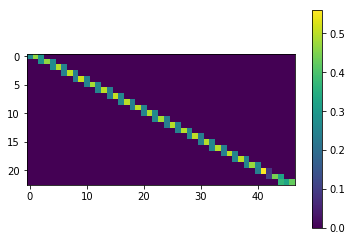

In [7]:
localR = opt_par[1][0]
LOCALR = np.zeros([outputsize-1,inputsize-2])
for i in range(outputsize-1):
    C = localR[i][:]
    for l in range(3):
        LOCALR[i][2*i+l] = C[l]
        
        
plt.imshow(LOCALR)
plt.colorbar()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)


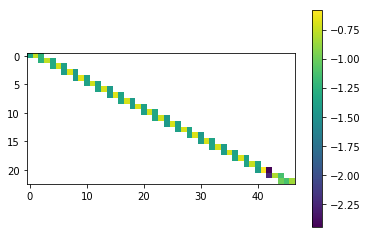

In [8]:
plt.imshow(np.log(np.abs(LOCALR)))
plt.colorbar()

In [9]:
Rnew, wnew, Rhoold, Rhonew, Radius = homotopy_optimizer_GD(inputsize, A0, A1.to_full(), R,  2/3, s, learning_rate = 1e-7,accept_radius = 1 ,step_length = 1e-2, lam = np.zeros([1,outputsize]))

======Section 1======
L = 0.02
rho = 0.11923644565536796
L = 0.03
rho = 0.11972722479470639
L = 0.04
rho = 0.12042095336843811
L = 0.05
rho = 0.12123181667326713
L = 0.060000000000000005
rho = 0.12210729965726531
L = 0.07
rho = 0.12301881789034562
L = 0.08
rho = 0.12395127269691754
L = 0.09
rho = 0.12489662284636847
L = 0.09999999999999999
rho = 0.12585050056672162
L = 0.10999999999999999
rho = 0.12681048915260448
L = 0.11999999999999998
rho = 0.12777523471036925
L = 0.12999999999999998
rho = 0.1287439748760377
L = 0.13999999999999999
rho = 0.1297162813840252
L = 0.15
rho = 0.13069191599645405
L = 0.16
rho = 0.1316707483104934
L = 0.17
rho = 0.1326527080596369
L = 0.18000000000000002
rho = 0.13363775688602386
L = 0.19000000000000003
rho = 0.13462587118011
L = 0.20000000000000004
rho = 0.13561703125808983
L = 0.21000000000000005
rho = 0.13661121423602732
L = 0.22000000000000006
rho = 0.13760838915693857
L = 0.23000000000000007
rho = 0.1386085136065484
L = 0.24000000000000007
rho = 0.139

the 44 steps
rho = 0.21644607829735688
the 45 steps
rho = 0.2164422240947259
the 46 steps
rho = 0.21643837343916936
the 47 steps
rho = 0.21643452632563795
the 48 steps
rho = 0.21643068274908248
the 49 steps
rho = 0.21642684270445958
the 50 steps
rho = 0.2164230061867301
the 51 steps
rho = 0.21641917319085308
the 52 steps
rho = 0.21641534371179744
the 53 steps
rho = 0.21641151774452794
the 54 steps
rho = 0.21640769528401999
the 55 steps
rho = 0.2164038763252486
the 56 steps
rho = 0.21640006086318922
the 57 steps
rho = 0.2163962488928257
the 58 steps
rho = 0.21639244040914596
the 59 steps
rho = 0.21638863540713776
the 60 steps
rho = 0.21638483388179158
the 61 steps
rho = 0.21638103582810506
the 62 steps
rho = 0.21637724124107538
the 63 steps
rho = 0.21637345011570758
the 64 steps
rho = 0.21636966244700298
the 65 steps
rho = 0.21636587822997772
the 66 steps
rho = 0.216362097459643
the 67 steps
rho = 0.2163583201310111
the 68 steps
rho = 0.21635454623910508
the 69 steps
rho = 0.21635077577

the 199 steps
rho = 0.21588802217523753
the 200 steps
rho = 0.21588465979805263
the 201 steps
rho = 0.2158813002323825
the 202 steps
rho = 0.21587794347383946
the 203 steps
rho = 0.21587458951803615
the 204 steps
rho = 0.21587123836059632
the 205 steps
rho = 0.21586788999714582
the 206 steps
rho = 0.21586454442331685
the 207 steps
rho = 0.21586120163474404
the 208 steps
rho = 0.21585786162707146
the 209 steps
rho = 0.21585452439594197
the 210 steps
rho = 0.21585118993700975
the 211 steps
rho = 0.21584785824592845
the 212 steps
rho = 0.21584452931836484
the 213 steps
rho = 0.2158412031499807
the 214 steps
rho = 0.2158378797364522
the 215 steps
rho = 0.2158345590734515
the 216 steps
rho = 0.2158312411566652
the 217 steps
rho = 0.2158279259817816
the 218 steps
rho = 0.2158246135444863
the 219 steps
rho = 0.21582130384048326
the 220 steps
rho = 0.2158179968654696
the 221 steps
rho = 0.21581469261516018
the 222 steps
rho = 0.2158113910852605
the 223 steps
rho = 0.21580809227149128
the 224 s

the 339 steps
rho = 0.21544276012559982
the 340 steps
rho = 0.21543975097639548
the 341 steps
rho = 0.21543674407501118
the 342 steps
rho = 0.21543373941779825
the 343 steps
rho = 0.21543073700110718
the 344 steps
rho = 0.21542773682129518
the 345 steps
rho = 0.21542473887473013
the 346 steps
rho = 0.21542174315778037
the 347 steps
rho = 0.21541874966682323
the 348 steps
rho = 0.2154157583982334
the 349 steps
rho = 0.21541276934839917
the 350 steps
rho = 0.2154097825137103
the 351 steps
rho = 0.21540679789056796
the 352 steps
rho = 0.21540381547536544
the 353 steps
rho = 0.21540083526451448
the 354 steps
rho = 0.21539785725442787
the 355 steps
rho = 0.21539488144151986
the 356 steps
rho = 0.21539190782221757
the 357 steps
rho = 0.21538893639294357
the 358 steps
rho = 0.2153859671501328
the 359 steps
rho = 0.21538300009022743
the 360 steps
rho = 0.21538003520966717
the 361 steps
rho = 0.21537707250490168
the 362 steps
rho = 0.2153741119723894
the 363 steps
rho = 0.21537115360858675
the 

the 488 steps
rho = 0.2150173124084517
the 489 steps
rho = 0.2150146007588352
the 490 steps
rho = 0.21501189087046157
the 491 steps
rho = 0.21500918274044414
the 492 steps
rho = 0.2150064763658976
the 493 steps
rho = 0.2150037717439504
the 494 steps
rho = 0.21500106887172257
the 495 steps
rho = 0.2149983677463578
the 496 steps
rho = 0.21499566836498774
the 497 steps
rho = 0.21499297072475354
the 498 steps
rho = 0.21499027482280514
the 499 steps
rho = 0.21498758065629736
the 500 steps
rho = 0.21498488822237963
the 501 steps
rho = 0.21498219751822129
the 502 steps
rho = 0.21497950854098571
the 503 steps
rho = 0.21497682128784304
the 504 steps
rho = 0.21497413575597296
the 505 steps
rho = 0.2149714519425538
the 506 steps
rho = 0.21496876984477178
the 507 steps
rho = 0.21496608945981566
the 508 steps
rho = 0.2149634107848847
the 509 steps
rho = 0.2149607338171761
the 510 steps
rho = 0.21495805855389416
the 511 steps
rho = 0.21495538499225053
the 512 steps
rho = 0.21495271312945935
the 513 

the 634 steps
rho = 0.21463867319263066
the 635 steps
rho = 0.21463619050120294
the 636 steps
rho = 0.2146337091982728
the 637 steps
rho = 0.21463122928160497
the 638 steps
rho = 0.2146287507489728
the 639 steps
rho = 0.21462627359814385
the 640 steps
rho = 0.21462379782690244
the 641 steps
rho = 0.21462132343302687
the 642 steps
rho = 0.21461885041429998
the 643 steps
rho = 0.21461637876851428
the 644 steps
rho = 0.21461390849346473
the 645 steps
rho = 0.21461143958694678
the 646 steps
rho = 0.21460897204676307
the 647 steps
rho = 0.21460650587071745
the 648 steps
rho = 0.2146040410566215
the 649 steps
rho = 0.21460157760228954
the 650 steps
rho = 0.21459911550553779
the 651 steps
rho = 0.21459665476418663
the 652 steps
rho = 0.214594195376065
the 653 steps
rho = 0.21459173733899967
the 654 steps
rho = 0.21458928065082467
the 655 steps
rho = 0.21458682530937784
the 656 steps
rho = 0.21458437131250008
the 657 steps
rho = 0.21458191865803822
the 658 steps
rho = 0.2145794673438409
the 65

the 786 steps
rho = 0.21427603924014468
the 787 steps
rho = 0.21427374415782566
the 788 steps
rho = 0.21427145016753926
the 789 steps
rho = 0.21426915726760085
the 790 steps
rho = 0.21426686545632914
the 791 steps
rho = 0.2142645747320473
the 792 steps
rho = 0.214262285093078
the 793 steps
rho = 0.2142599965377504
the 794 steps
rho = 0.21425770906439537
the 795 steps
rho = 0.21425542267134828
the 796 steps
rho = 0.21425313735695
the 797 steps
rho = 0.21425085311953376
the 798 steps
rho = 0.21424856995744856
the 799 steps
rho = 0.21424628786904007
the 800 steps
rho = 0.2142440068526599
the 801 steps
rho = 0.21424172690665833
the 802 steps
rho = 0.21423944802939418
the 803 steps
rho = 0.21423717021922786
the 804 steps
rho = 0.2142348934745217
the 805 steps
rho = 0.2142326177936392
the 806 steps
rho = 0.2142303431749512
the 807 steps
rho = 0.21422806961682866
the 808 steps
rho = 0.21422579711764805
the 809 steps
rho = 0.21422352567578534
the 810 steps
rho = 0.21422125528962435
the 811 ste

the 941 steps
rho = 0.21393237958191846
the 942 steps
rho = 0.2139302354786768
the 943 steps
rho = 0.2139280922412412
the 944 steps
rho = 0.21392594986836516
the 945 steps
rho = 0.213923808358798
the 946 steps
rho = 0.21392166771129237
the 947 steps
rho = 0.2139195279246045
the 948 steps
rho = 0.21391738899749235
the 949 steps
rho = 0.21391525092871552
the 950 steps
rho = 0.21391311371703964
the 951 steps
rho = 0.2139109773612265
the 952 steps
rho = 0.2139088418600448
the 953 steps
rho = 0.21390670721226404
the 954 steps
rho = 0.2139045734166588
the 955 steps
rho = 0.21390244047200227
the 956 steps
rho = 0.21390030837706997
the 957 steps
rho = 0.2138981771306452
the 958 steps
rho = 0.21389604673150622
the 959 steps
rho = 0.21389391717843895
the 960 steps
rho = 0.21389178847022997
the 961 steps
rho = 0.213889660605666
the 962 steps
rho = 0.21388753358354162
the 963 steps
rho = 0.21388540740264742
the 964 steps
rho = 0.21388328206178192
the 965 steps
rho = 0.21388115755974127
the 966 ste

rho = 0.21359349980373837
the 1105 steps
rho = 0.21359148189357793
the 1106 steps
rho = 0.2135894646741273
the 1107 steps
rho = 0.21358744814447364
the 1108 steps
rho = 0.21358543230370708
the 1109 steps
rho = 0.2135834171509214
the 1110 steps
rho = 0.213581402685205
the 1111 steps
rho = 0.2135793889056553
the 1112 steps
rho = 0.21357737581136743
the 1113 steps
rho = 0.21357536340144206
the 1114 steps
rho = 0.21357335167497543
the 1115 steps
rho = 0.21357134063107128
the 1116 steps
rho = 0.213569330268833
the 1117 steps
rho = 0.21356732058736633
the 1118 steps
rho = 0.21356531158577985
the 1119 steps
rho = 0.21356330326317902
the 1120 steps
rho = 0.2135612956186738
the 1121 steps
rho = 0.21355928865137896
the 1122 steps
rho = 0.21355728236040805
the 1123 steps
rho = 0.21355527674487443
the 1124 steps
rho = 0.21355327180389783
the 1125 steps
rho = 0.21355126753659526
the 1126 steps
rho = 0.2135492639420913
the 1127 steps
rho = 0.2135472610195008
the 1128 steps
rho = 0.21354525876795544


the 1249 steps
rho = 0.21330768945069364
the 1250 steps
rho = 0.21330576299162027
the 1251 steps
rho = 0.21330383710783893
the 1252 steps
rho = 0.21330191179865735
the 1253 steps
rho = 0.21329998706339068
the 1254 steps
rho = 0.21329806290135062
the 1255 steps
rho = 0.2132961393118538
the 1256 steps
rho = 0.21329421629421627
the 1257 steps
rho = 0.2132922938477561
the 1258 steps
rho = 0.21329037197179115
the 1259 steps
rho = 0.21328845066564392
the 1260 steps
rho = 0.2132865299286353
the 1261 steps
rho = 0.21328460976009
the 1262 steps
rho = 0.2132826901593288
the 1263 steps
rho = 0.21328077112568103
the 1264 steps
rho = 0.21327885265847168
the 1265 steps
rho = 0.21327693475703074
the 1266 steps
rho = 0.21327501742068494
the 1267 steps
rho = 0.21327310064876845
the 1268 steps
rho = 0.2132711844406099
the 1269 steps
rho = 0.21326926879554783
the 1270 steps
rho = 0.21326735371291472
the 1271 steps
rho = 0.21326543919204494
the 1272 steps
rho = 0.21326352523227826
the 1273 steps
rho = 0.2

the 1393 steps
rho = 0.21303588850550625
the 1394 steps
rho = 0.21303403840203866
the 1395 steps
rho = 0.2130321887871718
the 1396 steps
rho = 0.21303033966038545
the 1397 steps
rho = 0.21302849102115717
the 1398 steps
rho = 0.21302664286896836
the 1399 steps
rho = 0.21302479520329876
the 1400 steps
rho = 0.21302294802363078
the 1401 steps
rho = 0.2130211013294455
the 1402 steps
rho = 0.21301925512023062
the 1403 steps
rho = 0.21301740939546757
the 1404 steps
rho = 0.21301556415464357
the 1405 steps
rho = 0.21301371939724723
the 1406 steps
rho = 0.21301187512276246
the 1407 steps
rho = 0.21301003133067903
the 1408 steps
rho = 0.21300818802049037
the 1409 steps
rho = 0.2130063451916833
the 1410 steps
rho = 0.2130045028437523
the 1411 steps
rho = 0.2130026609761872
the 1412 steps
rho = 0.2130008195884841
the 1413 steps
rho = 0.21299897868013729
the 1414 steps
rho = 0.2129971382506405
the 1415 steps
rho = 0.21299529829949143
the 1416 steps
rho = 0.21299345882618886
the 1417 steps
rho = 0.

the 1531 steps
rho = 0.2127849829551941
the 1532 steps
rho = 0.21278319574415003
the 1533 steps
rho = 0.21278140895829875
the 1534 steps
rho = 0.21277962259723773
the 1535 steps
rho = 0.2127778366605726
the 1536 steps
rho = 0.2127760511478958
the 1537 steps
rho = 0.21277426605881253
the 1538 steps
rho = 0.21277248139292132
the 1539 steps
rho = 0.21277069714982808
the 1540 steps
rho = 0.2127689133291315
the 1541 steps
rho = 0.21276712993043911
the 1542 steps
rho = 0.212765346953354
the 1543 steps
rho = 0.21276356439748195
the 1544 steps
rho = 0.2127617822624263
the 1545 steps
rho = 0.21276000054779576
the 1546 steps
rho = 0.21275821925319918
the 1547 steps
rho = 0.2127564383782412
the 1548 steps
rho = 0.21275465792253495
the 1549 steps
rho = 0.21275287788568717
the 1550 steps
rho = 0.21275109826730756
the 1551 steps
rho = 0.21274931906701047
the 1552 steps
rho = 0.21274754028440576
the 1553 steps
rho = 0.2127457619191052
the 1554 steps
rho = 0.2127439839707237
the 1555 steps
rho = 0.212

the 1670 steps
rho = 0.21254047348129237
the 1671 steps
rho = 0.21253874183144328
the 1672 steps
rho = 0.21253701055762317
the 1673 steps
rho = 0.21253527965951888
the 1674 steps
rho = 0.21253354913682262
the 1675 steps
rho = 0.21253181898922646
the 1676 steps
rho = 0.21253008921642177
the 1677 steps
rho = 0.2125283598181034
the 1678 steps
rho = 0.21252663079396306
the 1679 steps
rho = 0.21252490214369454
the 1680 steps
rho = 0.21252317386699293
the 1681 steps
rho = 0.2125214459635522
the 1682 steps
rho = 0.2125197184330699
the 1683 steps
rho = 0.21251799127524038
the 1684 steps
rho = 0.2125162644897623
the 1685 steps
rho = 0.21251453807633264
the 1686 steps
rho = 0.21251281203464617
the 1687 steps
rho = 0.21251108636440622
the 1688 steps
rho = 0.21250936106530904
the 1689 steps
rho = 0.21250763613705329
the 1690 steps
rho = 0.21250591157934162
the 1691 steps
rho = 0.2125041873918756
the 1692 steps
rho = 0.21250246357435273
the 1693 steps
rho = 0.21250074012647557
the 1694 steps
rho = 

the 1822 steps
rho = 0.21228141200394512
the 1823 steps
rho = 0.21227973426535307
the 1824 steps
rho = 0.2122780568617353
the 1825 steps
rho = 0.21227637979285638
the 1826 steps
rho = 0.21227470305848334
the 1827 steps
rho = 0.21227302665838443
the 1828 steps
rho = 0.21227135059232338
the 1829 steps
rho = 0.2122696748600717
the 1830 steps
rho = 0.21226799946139505
the 1831 steps
rho = 0.2122663243960641
the 1832 steps
rho = 0.2122646496638447
the 1833 steps
rho = 0.2122629752645095
the 1834 steps
rho = 0.21226130119782516
the 1835 steps
rho = 0.21225962746356597
the 1836 steps
rho = 0.21225795406149686
the 1837 steps
rho = 0.21225628099139704
the 1838 steps
rho = 0.21225460825303094
the 1839 steps
rho = 0.21225293584617438
the 1840 steps
rho = 0.21225126377059522
the 1841 steps
rho = 0.21224959202607155
the 1842 steps
rho = 0.21224792061237113
the 1843 steps
rho = 0.21224624952927468
the 1844 steps
rho = 0.2122445787765504
the 1845 steps
rho = 0.21224290835397222
the 1846 steps
rho = 0

the 1988 steps
rho = 0.21200733188334875
the 1989 steps
rho = 0.21200570684057987
the 1990 steps
rho = 0.212004082099193
the 1991 steps
rho = 0.21200245765901413
the 1992 steps
rho = 0.21200083351986942
the 1993 steps
rho = 0.21199920968158778
the 1994 steps
rho = 0.21199758614399386
the 1995 steps
rho = 0.21199596290691636
the 1996 steps
rho = 0.21199433997018177
the 1997 steps
rho = 0.2119927173336215
the 1998 steps
rho = 0.21199109499706004
the 1999 steps
rho = 0.21198947296032944
the 2000 steps
rho = 0.2119878512232578
the 2001 steps
rho = 0.21198622978567538
the 2002 steps
rho = 0.21198460864740903
the 2003 steps
rho = 0.21198298780829056
the 2004 steps
rho = 0.2119813672681515
the 2005 steps
rho = 0.21197974702682007
the 2006 steps
rho = 0.2119781270841296
the 2007 steps
rho = 0.21197650743990842
the 2008 steps
rho = 0.21197488809399098
the 2009 steps
rho = 0.2119732690462073
the 2010 steps
rho = 0.21197165029639065
the 2011 steps
rho = 0.2119700318443712
the 2012 steps
rho = 0.2

the 2128 steps
rho = 0.2117826850891262
the 2129 steps
rho = 0.2117811006790278
the 2130 steps
rho = 0.21177951654873764
the 2131 steps
rho = 0.21177793269812537
the 2132 steps
rho = 0.21177634912704862
the 2133 steps
rho = 0.21177476583537547
the 2134 steps
rho = 0.21177318282296925
the 2135 steps
rho = 0.2117716000896979
the 2136 steps
rho = 0.2117700176354255
the 2137 steps
rho = 0.21176843546001414
the 2138 steps
rho = 0.2117668535633323
the 2139 steps
rho = 0.21176527194524608
the 2140 steps
rho = 0.21176369060562075
the 2141 steps
rho = 0.21176210954432337
the 2142 steps
rho = 0.21176052876121942
the 2143 steps
rho = 0.2117589482561775
the 2144 steps
rho = 0.21175736802906353
the 2145 steps
rho = 0.21175578807974477
the 2146 steps
rho = 0.21175420840808767
the 2147 steps
rho = 0.21175262901396327
the 2148 steps
rho = 0.21175104989723428
the 2149 steps
rho = 0.21174947105777536
the 2150 steps
rho = 0.2117478924954485
the 2151 steps
rho = 0.2117463142101285
the 2152 steps
rho = 0.2

the 2292 steps
rho = 0.21152649004533194
the 2293 steps
rho = 0.21152494986340487
the 2294 steps
rho = 0.21152340994181482
the 2295 steps
rho = 0.21152187028045943
the 2296 steps
rho = 0.21152033087923577
the 2297 steps
rho = 0.2115187917380407
the 2298 steps
rho = 0.21151725285677228
the 2299 steps
rho = 0.21151571423532617
the 2300 steps
rho = 0.2115141758736035
the 2301 steps
rho = 0.2115126377714997
the 2302 steps
rho = 0.21151109992891257
the 2303 steps
rho = 0.2115095623457415
the 2304 steps
rho = 0.2115080250218851
the 2305 steps
rho = 0.21150648795724344
the 2306 steps
rho = 0.21150495115171083
the 2307 steps
rho = 0.2115034146051903
the 2308 steps
rho = 0.21150187831757983
the 2309 steps
rho = 0.2115003422887787
the 2310 steps
rho = 0.21149880651868525
the 2311 steps
rho = 0.21149727100720167
the 2312 steps
rho = 0.21149573575422473
the 2313 steps
rho = 0.21149420075965591
the 2314 steps
rho = 0.2114926660233944
the 2315 steps
rho = 0.21149113154534224
the 2316 steps
rho = 0.2

the 2436 steps
rho = 0.21130733682625427
the 2437 steps
rho = 0.21130583314933432
the 2438 steps
rho = 0.21130432971951058
the 2439 steps
rho = 0.21130282653670665
the 2440 steps
rho = 0.21130132360083478
the 2441 steps
rho = 0.21129982091181573
the 2442 steps
rho = 0.21129831846956973
the 2443 steps
rho = 0.21129681627401495
the 2444 steps
rho = 0.21129531432506946
the 2445 steps
rho = 0.21129381262265312
the 2446 steps
rho = 0.21129231116668432
the 2447 steps
rho = 0.21129080995708274
the 2448 steps
rho = 0.21128930899376805
the 2449 steps
rho = 0.21128780827666013
the 2450 steps
rho = 0.2112863078056777
the 2451 steps
rho = 0.2112848075807433
the 2452 steps
rho = 0.21128330760177294
the 2453 steps
rho = 0.2112818078686895
the 2454 steps
rho = 0.21128030838141193
the 2455 steps
rho = 0.21127880913986294
the 2456 steps
rho = 0.21127731014395928
the 2457 steps
rho = 0.21127581139362436
the 2458 steps
rho = 0.21127431288877715
the 2459 steps
rho = 0.21127281462934153
the 2460 steps
rho 

the 2578 steps
rho = 0.2110962522238433
the 2579 steps
rho = 0.2110947828733807
the 2580 steps
rho = 0.2110933137595945
the 2581 steps
rho = 0.21109184488241983
the 2582 steps
rho = 0.21109037624179183
the 2583 steps
rho = 0.21108890783764342
the 2584 steps
rho = 0.21108743966991003
the 2585 steps
rho = 0.2110859717385251
the 2586 steps
rho = 0.2110845040434254
the 2587 steps
rho = 0.21108303658454614
the 2588 steps
rho = 0.21108156936182018
the 2589 steps
rho = 0.21108010237518224
the 2590 steps
rho = 0.21107863562456863
the 2591 steps
rho = 0.21107716910991606
the 2592 steps
rho = 0.21107570283115673
the 2593 steps
rho = 0.21107423678822812
the 2594 steps
rho = 0.21107277098106597
the 2595 steps
rho = 0.21107130540960437
the 2596 steps
rho = 0.21106984007377977
the 2597 steps
rho = 0.21106837497352818
the 2598 steps
rho = 0.2110669101087869
the 2599 steps
rho = 0.2110654454794873
the 2600 steps
rho = 0.21106398108557048
the 2601 steps
rho = 0.21106251692697128
the 2602 steps
rho = 0.

the 2745 steps
rho = 0.21085410402085475
the 2746 steps
rho = 0.21085267335282015
the 2747 steps
rho = 0.21085124291169516
the 2748 steps
rho = 0.2108498126974302
the 2749 steps
rho = 0.21084838270997144
the 2750 steps
rho = 0.21084695294926836
the 2751 steps
rho = 0.21084552341526905
the 2752 steps
rho = 0.2108440941079227
the 2753 steps
rho = 0.2108426650271757
the 2754 steps
rho = 0.2108412361729772
the 2755 steps
rho = 0.21083980754527726
the 2756 steps
rho = 0.210838379144024
the 2757 steps
rho = 0.21083695096916366
the 2758 steps
rho = 0.21083552302064887
the 2759 steps
rho = 0.21083409529842367
the 2760 steps
rho = 0.210832667802442
the 2761 steps
rho = 0.21083124053265187
the 2762 steps
rho = 0.21082981348899907
the 2763 steps
rho = 0.21082838667143367
the 2764 steps
rho = 0.21082696007990764
the 2765 steps
rho = 0.21082553371436868
the 2766 steps
rho = 0.21082410757476433
the 2767 steps
rho = 0.21082268166104579
the 2768 steps
rho = 0.21082125597316434
the 2769 steps
rho = 0.2

the 2907 steps
rho = 0.21062526063214385
the 2908 steps
rho = 0.21062386609112332
the 2909 steps
rho = 0.21062247176941448
the 2910 steps
rho = 0.2106210776669774
the 2911 steps
rho = 0.21061968378376725
the 2912 steps
rho = 0.21061829011974464
the 2913 steps
rho = 0.21061689667486294
the 2914 steps
rho = 0.2106155034490849
the 2915 steps
rho = 0.21061411044236408
the 2916 steps
rho = 0.21061271765466044
the 2917 steps
rho = 0.21061132508593292
the 2918 steps
rho = 0.2106099327361374
the 2919 steps
rho = 0.21060854060523454
the 2920 steps
rho = 0.21060714869317923
the 2921 steps
rho = 0.21060575699993264
the 2922 steps
rho = 0.21060436552544995
the 2923 steps
rho = 0.21060297426969166
the 2924 steps
rho = 0.21060158323261802
the 2925 steps
rho = 0.2106001924141831
the 2926 steps
rho = 0.2105988018143462
the 2927 steps
rho = 0.21059741143306815
the 2928 steps
rho = 0.21059602127030602
the 2929 steps
rho = 0.2105946313260186
the 2930 steps
rho = 0.2105932416001624
the 2931 steps
rho = 0.

the 3042 steps
rho = 0.2104389649068414
the 3043 steps
rho = 0.210437599608298
the 3044 steps
rho = 0.21043623452375443
the 3045 steps
rho = 0.21043486965317476
the 3046 steps
rho = 0.21043350499651894
the 3047 steps
rho = 0.21043214055375686
the 3048 steps
rho = 0.21043077632484755
the 3049 steps
rho = 0.21042941230975615
the 3050 steps
rho = 0.21042804850844468
the 3051 steps
rho = 0.2104266849208788
the 3052 steps
rho = 0.21042532154702187
the 3053 steps
rho = 0.21042395838683595
the 3054 steps
rho = 0.21042259544028574
the 3055 steps
rho = 0.21042123270733665
the 3056 steps
rho = 0.21041987018794872
the 3057 steps
rho = 0.21041850788208927
the 3058 steps
rho = 0.21041714578972168
the 3059 steps
rho = 0.21041578391080631
the 3060 steps
rho = 0.21041442224531354
the 3061 steps
rho = 0.21041306079320268
the 3062 steps
rho = 0.21041169955443792
the 3063 steps
rho = 0.21041033852898489
the 3064 steps
rho = 0.21040897771680742
the 3065 steps
rho = 0.2104076171178667
the 3066 steps
rho = 

the 3206 steps
rho = 0.21021789085498177
the 3207 steps
rho = 0.21021656018760507
the 3208 steps
rho = 0.21021522972866252
the 3209 steps
rho = 0.21021389947812075
the 3210 steps
rho = 0.21021256943595235
the 3211 steps
rho = 0.21021123960212107
the 3212 steps
rho = 0.2102099099765959
the 3213 steps
rho = 0.21020858055934896
the 3214 steps
rho = 0.2102072513503451
the 3215 steps
rho = 0.21020592234955496
the 3216 steps
rho = 0.21020459355694515
the 3217 steps
rho = 0.210203264972487
the 3218 steps
rho = 0.2102019365961478
the 3219 steps
rho = 0.21020060842789484
the 3220 steps
rho = 0.2101992804676996
the 3221 steps
rho = 0.2101979527155289
the 3222 steps
rho = 0.21019662517135063
the 3223 steps
rho = 0.21019529783513446
the 3224 steps
rho = 0.2101939707068512
the 3225 steps
rho = 0.21019264378646765
the 3226 steps
rho = 0.210191317073951
the 3227 steps
rho = 0.21018999056927262
the 3228 steps
rho = 0.21018866427240113
the 3229 steps
rho = 0.2101873381833051
the 3230 steps
rho = 0.2101

the 3356 steps
rho = 0.21002060304230977
the 3357 steps
rho = 0.21001930329934215
the 3358 steps
rho = 0.2100180037603129
the 3359 steps
rho = 0.2100167044251944
the 3360 steps
rho = 0.2100154052939567
the 3361 steps
rho = 0.21001410636657208
the 3362 steps
rho = 0.21001280764301147
the 3363 steps
rho = 0.2100115091232473
the 3364 steps
rho = 0.21001021080725077
the 3365 steps
rho = 0.21000891269499478
the 3366 steps
rho = 0.21000761478644506
the 3367 steps
rho = 0.21000631708158016
the 3368 steps
rho = 0.21000501958036905
the 3369 steps
rho = 0.21000372228278497
the 3370 steps
rho = 0.21000242518879472
the 3371 steps
rho = 0.2100011282983751
the 3372 steps
rho = 0.20999983161149624
the 3373 steps
rho = 0.20999853512812985
the 3374 steps
rho = 0.20999723884824592
the 3375 steps
rho = 0.2099959427718173
the 3376 steps
rho = 0.20999464689881825
the 3377 steps
rho = 0.20999335122921653
the 3378 steps
rho = 0.20999205576298582
the 3379 steps
rho = 0.20999076050009924
the 3380 steps
rho = 0

the 3492 steps
rho = 0.20984569866302713
the 3493 steps
rho = 0.2098444263999094
the 3494 steps
rho = 0.20984315433698333
the 3495 steps
rho = 0.2098418824742223
the 3496 steps
rho = 0.20984061081159774
the 3497 steps
rho = 0.2098393393490848
the 3498 steps
rho = 0.2098380680866554
the 3499 steps
rho = 0.20983679702428348
the 3500 steps
rho = 0.20983552616194362
the 3501 steps
rho = 0.20983425549960738
the 3502 steps
rho = 0.2098329850372488
the 3503 steps
rho = 0.20983171477484092
the 3504 steps
rho = 0.20983044471235865
the 3505 steps
rho = 0.2098291748497737
the 3506 steps
rho = 0.20982790518706015
the 3507 steps
rho = 0.20982663572418925
the 3508 steps
rho = 0.2098253664611393
the 3509 steps
rho = 0.20982409739788058
the 3510 steps
rho = 0.20982282853438666
the 3511 steps
rho = 0.20982155987063117
the 3512 steps
rho = 0.2098202914065871
the 3513 steps
rho = 0.20981902314222906
the 3514 steps
rho = 0.20981775507753084
the 3515 steps
rho = 0.20981648721246363
the 3516 steps
rho = 0.2

the 3628 steps
rho = 0.2096744978176047
the 3629 steps
rho = 0.20967325253926203
the 3630 steps
rho = 0.20967200745756182
the 3631 steps
rho = 0.209670762572481
the 3632 steps
rho = 0.2096695178839925
the 3633 steps
rho = 0.20966827339206998
the 3634 steps
rho = 0.20966702909668972
the 3635 steps
rho = 0.2096657849978257
the 3636 steps
rho = 0.20966454109545068
the 3637 steps
rho = 0.2096632973895408
the 3638 steps
rho = 0.20966205388006962
the 3639 steps
rho = 0.20966081056701322
the 3640 steps
rho = 0.20965956745034506
the 3641 steps
rho = 0.20965832453003824
the 3642 steps
rho = 0.20965708180606932
the 3643 steps
rho = 0.2096558392784115
the 3644 steps
rho = 0.2096545969470413
the 3645 steps
rho = 0.20965335481192965
the 3646 steps
rho = 0.20965211287305513
the 3647 steps
rho = 0.20965087113038955
the 3648 steps
rho = 0.2096496295839078
the 3649 steps
rho = 0.2096483882335874
the 3650 steps
rho = 0.20964714707939722
the 3651 steps
rho = 0.20964590612131673
the 3652 steps
rho = 0.209

the 3787 steps
rho = 0.20947895193169883
the 3788 steps
rho = 0.20947773760191482
the 3789 steps
rho = 0.2094765234647704
the 3790 steps
rho = 0.20947530952023782
the 3791 steps
rho = 0.2094740957682966
the 3792 steps
rho = 0.20947288220891624
the 3793 steps
rho = 0.20947166884207657
the 3794 steps
rho = 0.2094704556677497
the 3795 steps
rho = 0.20946924268591138
the 3796 steps
rho = 0.20946802989654004
the 3797 steps
rho = 0.20946681729960523
the 3798 steps
rho = 0.20946560489508612
the 3799 steps
rho = 0.20946439268295577
the 3800 steps
rho = 0.20946318066318947
the 3801 steps
rho = 0.20946196883576532
the 3802 steps
rho = 0.20946075720065424
the 3803 steps
rho = 0.20945954575783227
the 3804 steps
rho = 0.20945833450727602
the 3805 steps
rho = 0.20945712344895967
the 3806 steps
rho = 0.20945591258285884
the 3807 steps
rho = 0.20945470190894871
the 3808 steps
rho = 0.2094534914272031
the 3809 steps
rho = 0.20945228113760025
the 3810 steps
rho = 0.20945107104011043
the 3811 steps
rho =

the 3926 steps
rho = 0.20931199680001247
the 3927 steps
rho = 0.20931080900869076
the 3928 steps
rho = 0.20930962140655804
the 3929 steps
rho = 0.20930843399358653
the 3930 steps
rho = 0.20930724676975537
the 3931 steps
rho = 0.2093060597350353
the 3932 steps
rho = 0.20930487288940497
the 3933 steps
rho = 0.20930368623283968
the 3934 steps
rho = 0.20930249976531204
the 3935 steps
rho = 0.20930131348679834
the 3936 steps
rho = 0.20930012739727574
the 3937 steps
rho = 0.20929894149671555
the 3938 steps
rho = 0.20929775578509632
the 3939 steps
rho = 0.20929657026239246
the 3940 steps
rho = 0.2092953849285793
the 3941 steps
rho = 0.20929419978363112
the 3942 steps
rho = 0.20929301482752338
the 3943 steps
rho = 0.20929183006023175
the 3944 steps
rho = 0.20929064548173235
the 3945 steps
rho = 0.20928946109199767
the 3946 steps
rho = 0.20928827689100493
the 3947 steps
rho = 0.20928709287872863
the 3948 steps
rho = 0.20928590905514446
the 3949 steps
rho = 0.20928472542022727
the 3950 steps
rho

the 4066 steps
rho = 0.20914753570410533
the 4067 steps
rho = 0.20914637415746204
the 4068 steps
rho = 0.20914521279652273
the 4069 steps
rho = 0.20914405162126817
the 4070 steps
rho = 0.20914289063166994
the 4071 steps
rho = 0.20914172982770363
the 4072 steps
rho = 0.20914056920934457
the 4073 steps
rho = 0.2091394087765672
the 4074 steps
rho = 0.20913824852934645
the 4075 steps
rho = 0.2091370884676588
the 4076 steps
rho = 0.2091359285914764
the 4077 steps
rho = 0.20913476890077676
the 4078 steps
rho = 0.20913360939553502
the 4079 steps
rho = 0.20913245007572462
the 4080 steps
rho = 0.2091312909413227
the 4081 steps
rho = 0.2091301319923017
the 4082 steps
rho = 0.20912897322863735
the 4083 steps
rho = 0.20912781465030478
the 4084 steps
rho = 0.20912665625728077
the 4085 steps
rho = 0.20912549804953756
the 4086 steps
rho = 0.20912434002705083
the 4087 steps
rho = 0.20912318218979772
the 4088 steps
rho = 0.2091220245377499
the 4089 steps
rho = 0.20912086707088506
the 4090 steps
rho = 0

the 4227 steps
rho = 0.20896290148048857
the 4228 steps
rho = 0.2089617695091664
the 4229 steps
rho = 0.20896063771949253
the 4230 steps
rho = 0.20895950611144398
the 4231 steps
rho = 0.20895837468499415
the 4232 steps
rho = 0.2089572434401196
the 4233 steps
rho = 0.208956112376794
the 4234 steps
rho = 0.20895498149498926
the 4235 steps
rho = 0.20895385079468393
the 4236 steps
rho = 0.2089527202758493
the 4237 steps
rho = 0.20895158993846163
the 4238 steps
rho = 0.20895045978249588
the 4239 steps
rho = 0.2089493298079244
the 4240 steps
rho = 0.20894820001472472
the 4241 steps
rho = 0.20894707040286906
the 4242 steps
rho = 0.20894594097233138
the 4243 steps
rho = 0.2089448117230875
the 4244 steps
rho = 0.20894368265511246
the 4245 steps
rho = 0.20894255376838008
the 4246 steps
rho = 0.20894142506286437
the 4247 steps
rho = 0.20894029653853985
the 4248 steps
rho = 0.20893916819538216
the 4249 steps
rho = 0.20893804003336422
the 4250 steps
rho = 0.2089369120524626
the 4251 steps
rho = 0.2

the 4385 steps
rho = 0.20878628650696376
the 4386 steps
rho = 0.20878518291817133
the 4387 steps
rho = 0.2087840795069585
the 4388 steps
rho = 0.20878297627329867
the 4389 steps
rho = 0.20878187321716507
the 4390 steps
rho = 0.20878077033853484
the 4391 steps
rho = 0.2087796676373787
the 4392 steps
rho = 0.20877856511367224
the 4393 steps
rho = 0.20877746276738646
the 4394 steps
rho = 0.20877636059849836
the 4395 steps
rho = 0.2087752586069823
the 4396 steps
rho = 0.20877415679280886
the 4397 steps
rho = 0.2087730551559552
the 4398 steps
rho = 0.20877195369639362
the 4399 steps
rho = 0.20877085241409635
the 4400 steps
rho = 0.20876975130904166
the 4401 steps
rho = 0.20876865038119777
the 4402 steps
rho = 0.20876754963054267
the 4403 steps
rho = 0.20876644905705002
the 4404 steps
rho = 0.208765348660691
the 4405 steps
rho = 0.20876424844144206
the 4406 steps
rho = 0.20876314839927634
the 4407 steps
rho = 0.20876204853416708
the 4408 steps
rho = 0.2087609488460861
the 4409 steps
rho = 0.

the 4540 steps
rho = 0.20861733366502075
the 4541 steps
rho = 0.20861625728679867
the 4542 steps
rho = 0.20861518108205535
the 4543 steps
rho = 0.20861410505076505
the 4544 steps
rho = 0.20861302919290084
the 4545 steps
rho = 0.20861195350843692
the 4546 steps
rho = 0.20861087799734376
the 4547 steps
rho = 0.20860980265959617
the 4548 steps
rho = 0.20860872749516782
the 4549 steps
rho = 0.20860765250403207
the 4550 steps
rho = 0.20860657768615987
the 4551 steps
rho = 0.20860550304152628
the 4552 steps
rho = 0.20860442857010444
the 4553 steps
rho = 0.20860335427186563
the 4554 steps
rho = 0.20860228014678567
the 4555 steps
rho = 0.20860120619483638
the 4556 steps
rho = 0.20860013241599018
the 4557 steps
rho = 0.20859905881022053
the 4558 steps
rho = 0.20859798537750096
the 4559 steps
rho = 0.20859691211780437
the 4560 steps
rho = 0.2085958390311056
the 4561 steps
rho = 0.20859476611737426
the 4562 steps
rho = 0.20859369337658554
the 4563 steps
rho = 0.2085926208087119
the 4564 steps
rho

the 4686 steps
rho = 0.20846200501440024
the 4687 steps
rho = 0.20846095367791642
the 4688 steps
rho = 0.20845990251094648
the 4689 steps
rho = 0.20845885151346316
the 4690 steps
rho = 0.2084578006854377
the 4691 steps
rho = 0.20845675002684483
the 4692 steps
rho = 0.2084556995376553
the 4693 steps
rho = 0.20845464921784093
the 4694 steps
rho = 0.2084535990673748
the 4695 steps
rho = 0.2084525490862299
the 4696 steps
rho = 0.20845149927437914
the 4697 steps
rho = 0.2084504496317959
the 4698 steps
rho = 0.20844940015844837
the 4699 steps
rho = 0.20844835085431257
the 4700 steps
rho = 0.20844730171935996
the 4701 steps
rho = 0.20844625275356352
the 4702 steps
rho = 0.20844520395689442
the 4703 steps
rho = 0.20844415532932606
the 4704 steps
rho = 0.2084431068708306
the 4705 steps
rho = 0.20844205858138018
the 4706 steps
rho = 0.20844101046094832
the 4707 steps
rho = 0.20843996250950575
the 4708 steps
rho = 0.2084389147270262
the 4709 steps
rho = 0.2084378671134814
the 4710 steps
rho = 0.2

the 4833 steps
rho = 0.2083092632438853
the 4834 steps
rho = 0.20830823652821254
the 4835 steps
rho = 0.2083072099779587
the 4836 steps
rho = 0.20830618359309572
the 4837 steps
rho = 0.20830515737359448
the 4838 steps
rho = 0.20830413131942802
the 4839 steps
rho = 0.20830310543056674
the 4840 steps
rho = 0.20830207970698322
the 4841 steps
rho = 0.20830105414865033
the 4842 steps
rho = 0.2083000287555371
the 4843 steps
rho = 0.20829900352761696
the 4844 steps
rho = 0.20829797846486306
the 4845 steps
rho = 0.2082969535672424
the 4846 steps
rho = 0.20829592883473305
the 4847 steps
rho = 0.20829490426730338
the 4848 steps
rho = 0.2082938798649249
the 4849 steps
rho = 0.2082928556275702
the 4850 steps
rho = 0.2082918315552105
the 4851 steps
rho = 0.20829080764781643
the 4852 steps
rho = 0.20828978390536323
the 4853 steps
rho = 0.20828876032781915
the 4854 steps
rho = 0.20828773691515895
the 4855 steps
rho = 0.20828671366735016
the 4856 steps
rho = 0.20828569058436955
the 4857 steps
rho = 0.

the 4974 steps
rho = 0.20816611605160912
the 4975 steps
rho = 0.20816511237964563
the 4976 steps
rho = 0.20816410886908251
the 4977 steps
rho = 0.2081631055198904
the 4978 steps
rho = 0.20816210233204072
the 4979 steps
rho = 0.20816109930550283
the 4980 steps
rho = 0.20816009644025218
the 4981 steps
rho = 0.2081590937362557
the 4982 steps
rho = 0.20815809119348644
the 4983 steps
rho = 0.20815708881191367
the 4984 steps
rho = 0.20815608659151028
the 4985 steps
rho = 0.20815508453225037
the 4986 steps
rho = 0.2081540826340986
the 4987 steps
rho = 0.20815308089703233
the 4988 steps
rho = 0.20815207932101795
the 4989 steps
rho = 0.2081510779060266
the 4990 steps
rho = 0.20815007665203353
the 4991 steps
rho = 0.2081490755590086
the 4992 steps
rho = 0.2081480746269209
the 4993 steps
rho = 0.20814707385574102
the 4994 steps
rho = 0.208146073245445
the 4995 steps
rho = 0.2081450727960006
the 4996 steps
rho = 0.2081440725073765
the 4997 steps
rho = 0.2081430723795471
the 4998 steps
rho = 0.2081

the 5116 steps
rho = 0.20802519688498855
the 5117 steps
rho = 0.20802421584160324
the 5118 steps
rho = 0.20802323495548847
the 5119 steps
rho = 0.20802225422661522
the 5120 steps
rho = 0.2080212736549543
the 5121 steps
rho = 0.20802029324047622
the 5122 steps
rho = 0.20801931298315057
the 5123 steps
rho = 0.20801833288295007
the 5124 steps
rho = 0.2080173529398435
the 5125 steps
rho = 0.20801637315380225
the 5126 steps
rho = 0.20801539352479873
the 5127 steps
rho = 0.20801441405280102
the 5128 steps
rho = 0.20801343473778014
the 5129 steps
rho = 0.20801245557970632
the 5130 steps
rho = 0.20801147657855282
the 5131 steps
rho = 0.20801049773428792
the 5132 steps
rho = 0.20800951904688267
the 5133 steps
rho = 0.20800854051630668
the 5134 steps
rho = 0.20800756214253274
the 5135 steps
rho = 0.2080065839255303
the 5136 steps
rho = 0.20800560586527003
the 5137 steps
rho = 0.2080046279617231
the 5138 steps
rho = 0.20800365021485853
the 5139 steps
rho = 0.2080026726246475
the 5140 steps
rho = 

the 5263 steps
rho = 0.2078826559002901
the 5264 steps
rho = 0.20788169765914594
the 5265 steps
rho = 0.20788073957092476
the 5266 steps
rho = 0.20787978163559676
the 5267 steps
rho = 0.2078788238531311
the 5268 steps
rho = 0.20787786622349833
the 5269 steps
rho = 0.20787690874667183
the 5270 steps
rho = 0.20787595142261703
the 5271 steps
rho = 0.20787499425130687
the 5272 steps
rho = 0.20787403723271003
the 5273 steps
rho = 0.2078730803667991
the 5274 steps
rho = 0.20787212365354119
the 5275 steps
rho = 0.20787116709290832
the 5276 steps
rho = 0.20787021068486888
the 5277 steps
rho = 0.20786925442939844
the 5278 steps
rho = 0.20786829832646034
the 5279 steps
rho = 0.2078673423760284
the 5280 steps
rho = 0.20786638657807097
the 5281 steps
rho = 0.20786543093256024
the 5282 steps
rho = 0.20786447543946499
the 5283 steps
rho = 0.20786352009875506
the 5284 steps
rho = 0.20786256491040117
the 5285 steps
rho = 0.20786160987437452
the 5286 steps
rho = 0.20786065499064232
the 5287 steps
rho =

the 5413 steps
rho = 0.2077406121576237
the 5414 steps
rho = 0.20773967652042716
the 5415 steps
rho = 0.20773874103165438
the 5416 steps
rho = 0.20773780569127526
the 5417 steps
rho = 0.2077368704992599
the 5418 steps
rho = 0.20773593545557892
the 5419 steps
rho = 0.20773500056020056
the 5420 steps
rho = 0.20773406581309675
the 5421 steps
rho = 0.20773313121423556
the 5422 steps
rho = 0.2077321967635856
the 5423 steps
rho = 0.20773126246112184
the 5424 steps
rho = 0.20773032830680854
the 5425 steps
rho = 0.20772939430061765
the 5426 steps
rho = 0.2077284604425188
the 5427 steps
rho = 0.2077275267324826
the 5428 steps
rho = 0.20772659317047737
the 5429 steps
rho = 0.2077256597564745
the 5430 steps
rho = 0.2077247264904428
the 5431 steps
rho = 0.20772379337235275
the 5432 steps
rho = 0.2077228604021735
the 5433 steps
rho = 0.2077219275798761
the 5434 steps
rho = 0.2077209949054275
the 5435 steps
rho = 0.20772006237880172
the 5436 steps
rho = 0.2077191299999647
the 5437 steps
rho = 0.2077

the 5568 steps
rho = 0.20759734143180364
the 5569 steps
rho = 0.20759642843925794
the 5570 steps
rho = 0.2075955155904401
the 5571 steps
rho = 0.20759460288532144
the 5572 steps
rho = 0.20759369032386718
the 5573 steps
rho = 0.2075927779060526
the 5574 steps
rho = 0.2075918656318435
the 5575 steps
rho = 0.2075909535012102
the 5576 steps
rho = 0.20759004151412414
the 5577 steps
rho = 0.2075891296705525
the 5578 steps
rho = 0.20758821797046675
the 5579 steps
rho = 0.20758730641383458
the 5580 steps
rho = 0.20758639500062673
the 5581 steps
rho = 0.20758548373081193
the 5582 steps
rho = 0.20758457260436095
the 5583 steps
rho = 0.207583661621243
the 5584 steps
rho = 0.20758275078142743
the 5585 steps
rho = 0.20758184008488387
the 5586 steps
rho = 0.2075809295315806
the 5587 steps
rho = 0.20758001912149004
the 5588 steps
rho = 0.20757910885458128
the 5589 steps
rho = 0.2075781987308202
the 5590 steps
rho = 0.20757728875017972
the 5591 steps
rho = 0.20757637891262892
the 5592 steps
rho = 0.20

the 5728 steps
rho = 0.20745307045038827
the 5729 steps
rho = 0.2074521800669299
the 5730 steps
rho = 0.20745128982232472
the 5731 steps
rho = 0.20745039971653914
the 5732 steps
rho = 0.2074495097495472
the 5733 steps
rho = 0.2074486199213134
the 5734 steps
rho = 0.20744773023180949
the 5735 steps
rho = 0.2074468406810055
the 5736 steps
rho = 0.2074459512688681
the 5737 steps
rho = 0.20744506199537255
the 5738 steps
rho = 0.20744417286048172
the 5739 steps
rho = 0.2074432838641695
the 5740 steps
rho = 0.20744239500640183
the 5741 steps
rho = 0.20744150628715208
the 5742 steps
rho = 0.20744061770638716
the 5743 steps
rho = 0.20743972926407733
the 5744 steps
rho = 0.2074388409601908
the 5745 steps
rho = 0.2074379527947002
the 5746 steps
rho = 0.2074370647675714
the 5747 steps
rho = 0.20743617687877516
the 5748 steps
rho = 0.20743528912828205
the 5749 steps
rho = 0.2074344015160624
the 5750 steps
rho = 0.20743351404208066
the 5751 steps
rho = 0.20743262670631155
the 5752 steps
rho = 0.207

the 5888 steps
rho = 0.20731235484033414
the 5889 steps
rho = 0.20731148628485113
the 5890 steps
rho = 0.20731061786333851
the 5891 steps
rho = 0.2073097495757592
the 5892 steps
rho = 0.20730888142208953
the 5893 steps
rho = 0.20730801340229507
the 5894 steps
rho = 0.20730714551634738
the 5895 steps
rho = 0.20730627776421437
the 5896 steps
rho = 0.20730541014586704
the 5897 steps
rho = 0.2073045426612733
the 5898 steps
rho = 0.20730367531040506
the 5899 steps
rho = 0.20730280809323035
the 5900 steps
rho = 0.20730194100971747
the 5901 steps
rho = 0.2073010740598382
the 5902 steps
rho = 0.20730020724355996
the 5903 steps
rho = 0.2072993405608534
the 5904 steps
rho = 0.20729847401168838
the 5905 steps
rho = 0.2072976075960344
the 5906 steps
rho = 0.2072967413138587
the 5907 steps
rho = 0.20729587516513515
the 5908 steps
rho = 0.20729500914982799
the 5909 steps
rho = 0.20729414326791143
the 5910 steps
rho = 0.20729327751935167
the 5911 steps
rho = 0.20729241190412068
the 5912 steps
rho = 0

the 6035 steps
rho = 0.20718609898924725
the 6036 steps
rho = 0.20718524980016367
the 6037 steps
rho = 0.207184400740571
the 6038 steps
rho = 0.2071835518104437
the 6039 steps
rho = 0.2071827030097481
the 6040 steps
rho = 0.20718185433845424
the 6041 steps
rho = 0.2071810057965319
the 6042 steps
rho = 0.207180157383952
the 6043 steps
rho = 0.20717930910068455
the 6044 steps
rho = 0.20717846094669592
the 6045 steps
rho = 0.20717761292195985
the 6046 steps
rho = 0.2071767650264421
the 6047 steps
rho = 0.20717591726011614
the 6048 steps
rho = 0.20717506962294774
the 6049 steps
rho = 0.20717422211491057
the 6050 steps
rho = 0.2071733747359702
the 6051 steps
rho = 0.20717252748609932
the 6052 steps
rho = 0.207171680365266
the 6053 steps
rho = 0.20717083337344167
the 6054 steps
rho = 0.20716998651059354
the 6055 steps
rho = 0.20716913977669302
the 6056 steps
rho = 0.2071682931717107
the 6057 steps
rho = 0.20716744669561374
the 6058 steps
rho = 0.207166600348372
the 6059 steps
rho = 0.2071657

the 6173 steps
rho = 0.2070701220078883
the 6174 steps
rho = 0.20706929040254948
the 6175 steps
rho = 0.2070684589225304
the 6176 steps
rho = 0.20706762756779803
the 6177 steps
rho = 0.2070667963383256
the 6178 steps
rho = 0.20706596523408147
the 6179 steps
rho = 0.20706513425503428
the 6180 steps
rho = 0.2070643034011559
the 6181 steps
rho = 0.2070634726724139
the 6182 steps
rho = 0.20706264206878086
the 6183 steps
rho = 0.2070618115902242
the 6184 steps
rho = 0.20706098123671618
the 6185 steps
rho = 0.20706015100822533
the 6186 steps
rho = 0.20705932090472165
the 6187 steps
rho = 0.20705849092617404
the 6188 steps
rho = 0.20705766107255397
the 6189 steps
rho = 0.2070568313438318
the 6190 steps
rho = 0.20705600173997468
the 6191 steps
rho = 0.2070551722609555
the 6192 steps
rho = 0.20705434290674238
the 6193 steps
rho = 0.20705351367730654
the 6194 steps
rho = 0.20705268457261622
the 6195 steps
rho = 0.20705185559264297
the 6196 steps
rho = 0.20705102673735581
the 6197 steps
rho = 0.2

the 6324 steps
rho = 0.2069459519313586
the 6325 steps
rho = 0.2069451389091176
the 6326 steps
rho = 0.20694432600767218
the 6327 steps
rho = 0.2069435132269891
the 6328 steps
rho = 0.20694270056704178
the 6329 steps
rho = 0.20694188802779853
the 6330 steps
rho = 0.20694107560923092
the 6331 steps
rho = 0.20694026331130783
the 6332 steps
rho = 0.20693945113400053
the 6333 steps
rho = 0.2069386390772793
the 6334 steps
rho = 0.2069378271411141
the 6335 steps
rho = 0.20693701532547518
the 6336 steps
rho = 0.20693620363033155
the 6337 steps
rho = 0.206935392055657
the 6338 steps
rho = 0.20693458060141565
the 6339 steps
rho = 0.20693376926758414
the 6340 steps
rho = 0.20693295805413003
the 6341 steps
rho = 0.2069321469610232
the 6342 steps
rho = 0.20693133598823493
the 6343 steps
rho = 0.20693052513573337
the 6344 steps
rho = 0.2069297144034915
the 6345 steps
rho = 0.20692890379147766
the 6346 steps
rho = 0.20692809329966422
the 6347 steps
rho = 0.20692728292801854
the 6348 steps
rho = 0.20

the 6482 steps
rho = 0.20681897349086728
the 6483 steps
rho = 0.20681817918657944
the 6484 steps
rho = 0.206817384998416
the 6485 steps
rho = 0.2068165909263471
the 6486 steps
rho = 0.2068157969703451
the 6487 steps
rho = 0.2068150031303785
the 6488 steps
rho = 0.20681420940642178
the 6489 steps
rho = 0.206813415798441
the 6490 steps
rho = 0.2068126223064113
the 6491 steps
rho = 0.20681182893030056
the 6492 steps
rho = 0.20681103567007822
the 6493 steps
rho = 0.20681024252571978
the 6494 steps
rho = 0.20680944949719304
the 6495 steps
rho = 0.2068086565844683
the 6496 steps
rho = 0.20680786378751628
the 6497 steps
rho = 0.2068070711063093
the 6498 steps
rho = 0.2068062785408162
the 6499 steps
rho = 0.20680548609100924
the 6500 steps
rho = 0.20680469375685817
the 6501 steps
rho = 0.20680390153833475
the 6502 steps
rho = 0.20680310943540914
the 6503 steps
rho = 0.20680231744805133
the 6504 steps
rho = 0.20680152557623344
the 6505 steps
rho = 0.20680073381992548
the 6506 steps
rho = 0.2067

the 6620 steps
rho = 0.20671044471607974
the 6621 steps
rho = 0.20670966616142192
the 6622 steps
rho = 0.20670888771887663
the 6623 steps
rho = 0.20670810938841752
the 6624 steps
rho = 0.20670733117001228
the 6625 steps
rho = 0.20670655306363328
the 6626 steps
rho = 0.20670577506925114
the 6627 steps
rho = 0.20670499718683766
the 6628 steps
rho = 0.20670421941636463
the 6629 steps
rho = 0.20670344175780295
the 6630 steps
rho = 0.2067026642111228
the 6631 steps
rho = 0.20670188677629794
the 6632 steps
rho = 0.2067011094532966
the 6633 steps
rho = 0.20670033224209122
the 6634 steps
rho = 0.20669955514265378
the 6635 steps
rho = 0.20669877815495366
the 6636 steps
rho = 0.20669800127896387
the 6637 steps
rho = 0.20669722451465403
the 6638 steps
rho = 0.20669644786199848
the 6639 steps
rho = 0.20669567132096447
the 6640 steps
rho = 0.2066948948915253
the 6641 steps
rho = 0.20669411857365164
the 6642 steps
rho = 0.20669334236731546
the 6643 steps
rho = 0.2066925662724879
the 6644 steps
rho =

the 6760 steps
rho = 0.20660252508018176
the 6761 steps
rho = 0.20660176194260282
the 6762 steps
rho = 0.2066009989131387
the 6763 steps
rho = 0.2066002359917637
the 6764 steps
rho = 0.20659947317844693
the 6765 steps
rho = 0.2065987104731604
the 6766 steps
rho = 0.20659794787587704
the 6767 steps
rho = 0.20659718538656752
the 6768 steps
rho = 0.20659642300520395
the 6769 steps
rho = 0.20659566073175858
the 6770 steps
rho = 0.20659489856620294
the 6771 steps
rho = 0.2065941365085089
the 6772 steps
rho = 0.2065933745586468
the 6773 steps
rho = 0.20659261271659007
the 6774 steps
rho = 0.20659185098231006
the 6775 steps
rho = 0.20659108935577877
the 6776 steps
rho = 0.2065903278369669
the 6777 steps
rho = 0.20658956642584805
the 6778 steps
rho = 0.20658880512239106
the 6779 steps
rho = 0.20658804392657173
the 6780 steps
rho = 0.20658728283835903
the 6781 steps
rho = 0.20658652185772547
the 6782 steps
rho = 0.20658576098464385
the 6783 steps
rho = 0.2065850002190845
the 6784 steps
rho = 0.

the 6898 steps
rho = 0.20649822205851945
the 6899 steps
rho = 0.20649747357550302
the 6900 steps
rho = 0.20649672519674162
the 6901 steps
rho = 0.20649597692220806
the 6902 steps
rho = 0.20649522875187312
the 6903 steps
rho = 0.2064944806857107
the 6904 steps
rho = 0.2064937327236928
the 6905 steps
rho = 0.2064929848657925
the 6906 steps
rho = 0.20649223711198164
the 6907 steps
rho = 0.2064914894622328
the 6908 steps
rho = 0.20649074191651612
the 6909 steps
rho = 0.20648999447480654
the 6910 steps
rho = 0.20648924713707606
the 6911 steps
rho = 0.2064884999032973
the 6912 steps
rho = 0.20648775277344047
the 6913 steps
rho = 0.20648700574747955
the 6914 steps
rho = 0.20648625882538907
the 6915 steps
rho = 0.20648551200713805
the 6916 steps
rho = 0.20648476529270088
the 6917 steps
rho = 0.20648401868204738
the 6918 steps
rho = 0.20648327217515247
the 6919 steps
rho = 0.20648252577198833
the 6920 steps
rho = 0.20648177947252735
the 6921 steps
rho = 0.20648103327674017
the 6922 steps
rho = 

the 7052 steps
rho = 0.20638416749292074
the 7053 steps
rho = 0.20638343474199944
the 7054 steps
rho = 0.20638270209112825
the 7055 steps
rho = 0.20638196954027763
the 7056 steps
rho = 0.20638123708942305
the 7057 steps
rho = 0.20638050473853567
the 7058 steps
rho = 0.20637977248759065
the 7059 steps
rho = 0.20637904033655832
the 7060 steps
rho = 0.20637830828541417
the 7061 steps
rho = 0.20637757633413023
the 7062 steps
rho = 0.20637684448267954
the 7063 steps
rho = 0.20637611273103648
the 7064 steps
rho = 0.20637538107917208
the 7065 steps
rho = 0.20637464952706136
the 7066 steps
rho = 0.2063739180746747
the 7067 steps
rho = 0.20637318672198854
the 7068 steps
rho = 0.2063724554689749
the 7069 steps
rho = 0.20637172431560494
the 7070 steps
rho = 0.20637099326185399
the 7071 steps
rho = 0.2063702623076941
the 7072 steps
rho = 0.20636953145309936
the 7073 steps
rho = 0.20636880069804117
the 7074 steps
rho = 0.20636807004249663
the 7075 steps
rho = 0.20636733948643401
the 7076 steps
rho 

the 7212 steps
rho = 0.20626818204381642
the 7213 steps
rho = 0.20626746496123577
the 7214 steps
rho = 0.2062667479744554
the 7215 steps
rho = 0.20626603108345015
the 7216 steps
rho = 0.20626531428819253
the 7217 steps
rho = 0.20626459758865545
the 7218 steps
rho = 0.20626388098481324
the 7219 steps
rho = 0.2062631644766417
the 7220 steps
rho = 0.20626244806411284
the 7221 steps
rho = 0.20626173174719983
the 7222 steps
rho = 0.20626101552587903
the 7223 steps
rho = 0.2062602994001229
the 7224 steps
rho = 0.20625958336990488
the 7225 steps
rho = 0.20625886743520072
the 7226 steps
rho = 0.20625815159598077
the 7227 steps
rho = 0.2062574358522232
the 7228 steps
rho = 0.20625672020389968
the 7229 steps
rho = 0.2062560046509833
the 7230 steps
rho = 0.2062552891934504
the 7231 steps
rho = 0.20625457383127244
the 7232 steps
rho = 0.20625385856442477
the 7233 steps
rho = 0.20625314339288053
the 7234 steps
rho = 0.2062524283166149
the 7235 steps
rho = 0.20625171333560088
the 7236 steps
rho = 0.

the 7358 steps
rho = 0.2061644888349454
the 7359 steps
rho = 0.20616378546493455
the 7360 steps
rho = 0.20616308218695995
the 7361 steps
rho = 0.20616237900099604
the 7362 steps
rho = 0.20616167590701806
the 7363 steps
rho = 0.20616097290500005
the 7364 steps
rho = 0.20616026999491682
the 7365 steps
rho = 0.20615956717674083
the 7366 steps
rho = 0.20615886445045067
the 7367 steps
rho = 0.2061581618160173
the 7368 steps
rho = 0.20615745927341778
the 7369 steps
rho = 0.20615675682262538
the 7370 steps
rho = 0.20615605446361562
the 7371 steps
rho = 0.20615535219636216
the 7372 steps
rho = 0.20615465002084232
the 7373 steps
rho = 0.20615394793702646
the 7374 steps
rho = 0.2061532459448925
the 7375 steps
rho = 0.20615254404441305
the 7376 steps
rho = 0.20615184223556565
the 7377 steps
rho = 0.20615114051832173
the 7378 steps
rho = 0.2061504388926573
the 7379 steps
rho = 0.2061497373585495
the 7380 steps
rho = 0.20614903591596928
the 7381 steps
rho = 0.20614833456489254
the 7382 steps
rho = 

the 7507 steps
rho = 0.20606068787441006
the 7508 steps
rho = 0.20605999794057395
the 7509 steps
rho = 0.20605930809504716
the 7510 steps
rho = 0.20605861833780734
the 7511 steps
rho = 0.20605792866882727
the 7512 steps
rho = 0.206057239088083
the 7513 steps
rho = 0.20605654959555003
the 7514 steps
rho = 0.20605586019120498
the 7515 steps
rho = 0.20605517087502132
the 7516 steps
rho = 0.20605448164697715
the 7517 steps
rho = 0.20605379250704253
the 7518 steps
rho = 0.20605310345520003
the 7519 steps
rho = 0.20605241449142156
the 7520 steps
rho = 0.206051725615681
the 7521 steps
rho = 0.20605103682795733
the 7522 steps
rho = 0.20605034812822218
the 7523 steps
rho = 0.20604965951645343
the 7524 steps
rho = 0.20604897099262678
the 7525 steps
rho = 0.20604828255671653
the 7526 steps
rho = 0.20604759420869748
the 7527 steps
rho = 0.206046905948548
the 7528 steps
rho = 0.20604621777624124
the 7529 steps
rho = 0.20604552969175274
the 7530 steps
rho = 0.20604484169505913
the 7531 steps
rho = 0

the 7643 steps
rho = 0.20596765754073112
the 7644 steps
rho = 0.2059669793933459
the 7645 steps
rho = 0.20596630133097277
the 7646 steps
rho = 0.20596562335358923
the 7647 steps
rho = 0.20596494546117
the 7648 steps
rho = 0.2059642676536914
the 7649 steps
rho = 0.20596358993112923
the 7650 steps
rho = 0.20596291229346136
the 7651 steps
rho = 0.20596223474066502
the 7652 steps
rho = 0.2059615572727101
the 7653 steps
rho = 0.20596087988957995
the 7654 steps
rho = 0.20596020259124567
the 7655 steps
rho = 0.2059595253776874
the 7656 steps
rho = 0.20595884824887742
the 7657 steps
rho = 0.20595817120479476
the 7658 steps
rho = 0.20595749424541587
the 7659 steps
rho = 0.20595681737071542
the 7660 steps
rho = 0.20595614058066813
the 7661 steps
rho = 0.20595546387525324
the 7662 steps
rho = 0.20595478725444594
the 7663 steps
rho = 0.2059541107182228
the 7664 steps
rho = 0.20595343426655782
the 7665 steps
rho = 0.205952757899431
the 7666 steps
rho = 0.205952081616816
the 7667 steps
rho = 0.20595

the 7811 steps
rho = 0.20585490297758077
the 7812 steps
rho = 0.2058542387815928
the 7813 steps
rho = 0.20585357466668078
the 7814 steps
rho = 0.2058529106328251
the 7815 steps
rho = 0.20585224668000163
the 7816 steps
rho = 0.2058515828081847
the 7817 steps
rho = 0.20585091901735586
the 7818 steps
rho = 0.205850255307488
the 7819 steps
rho = 0.20584959167856148
the 7820 steps
rho = 0.20584892813055025
the 7821 steps
rho = 0.20584826466343478
the 7822 steps
rho = 0.2058476012771875
the 7823 steps
rho = 0.20584693797179202
the 7824 steps
rho = 0.20584627474721945
the 7825 steps
rho = 0.20584561160345066
the 7826 steps
rho = 0.2058449485404592
the 7827 steps
rho = 0.20584428555822568
the 7828 steps
rho = 0.20584362265672612
the 7829 steps
rho = 0.2058429598359372
the 7830 steps
rho = 0.20584229709583565
the 7831 steps
rho = 0.20584163443639963
the 7832 steps
rho = 0.20584097185760622
the 7833 steps
rho = 0.20584030935943085
the 7834 steps
rho = 0.20583964694185333
the 7835 steps
rho = 0.2

the 7989 steps
rho = 0.20573793230285295
the 7990 steps
rho = 0.20573728218192608
the 7991 steps
rho = 0.2057366321380746
the 7992 steps
rho = 0.20573598217127734
the 7993 steps
rho = 0.20573533228151034
the 7994 steps
rho = 0.2057346824687537
the 7995 steps
rho = 0.20573403273298385
the 7996 steps
rho = 0.20573338307417904
the 7997 steps
rho = 0.20573273349231888
the 7998 steps
rho = 0.2057320839873789
the 7999 steps
rho = 0.20573143455933907
the 8000 steps
rho = 0.20573078520817553
the 8001 steps
rho = 0.20573013593386988
the 8002 steps
rho = 0.20572948673639624
the 8003 steps
rho = 0.20572883761573357
the 8004 steps
rho = 0.20572818857186054
the 8005 steps
rho = 0.20572753960475604
the 8006 steps
rho = 0.20572689071439784
the 8007 steps
rho = 0.2057262419007628
the 8008 steps
rho = 0.2057255931638309
the 8009 steps
rho = 0.20572494450357828
the 8010 steps
rho = 0.20572429591998365
the 8011 steps
rho = 0.20572364741302543
the 8012 steps
rho = 0.20572299898268218
the 8013 steps
rho = 

the 8127 steps
rho = 0.20564893485752012
the 8128 steps
rho = 0.20564829516731598
the 8129 steps
rho = 0.20564765555120224
the 8130 steps
rho = 0.20564701600915652
the 8131 steps
rho = 0.20564637654115867
the 8132 steps
rho = 0.2056457371471853
the 8133 steps
rho = 0.20564509782722062
the 8134 steps
rho = 0.20564445858123656
the 8135 steps
rho = 0.20564381940921642
the 8136 steps
rho = 0.2056431803111369
the 8137 steps
rho = 0.20564254128697712
the 8138 steps
rho = 0.20564190233671742
the 8139 steps
rho = 0.20564126346033448
the 8140 steps
rho = 0.2056406246578076
the 8141 steps
rho = 0.2056399859291166
the 8142 steps
rho = 0.2056393472742399
the 8143 steps
rho = 0.20563870869315468
the 8144 steps
rho = 0.2056380701858417
the 8145 steps
rho = 0.20563743175227955
the 8146 steps
rho = 0.2056367933924463
the 8147 steps
rho = 0.20563615510632086
the 8148 steps
rho = 0.2056355168938825
the 8149 steps
rho = 0.20563487875511086
the 8150 steps
rho = 0.20563424068998312
the 8151 steps
rho = 0.2

the 8264 steps
rho = 0.20556197868334503
the 8265 steps
rho = 0.2055613489476259
the 8266 steps
rho = 0.2055607192831343
the 8267 steps
rho = 0.2055600896898465
the 8268 steps
rho = 0.20555946016774507
the 8269 steps
rho = 0.20555883071681055
the 8270 steps
rho = 0.205558201337018
the 8271 steps
rho = 0.20555757202835118
the 8272 steps
rho = 0.20555694279078754
the 8273 steps
rho = 0.20555631362430637
the 8274 steps
rho = 0.20555568452888842
the 8275 steps
rho = 0.20555505550451064
the 8276 steps
rho = 0.20555442655115594
the 8277 steps
rho = 0.20555379766880263
the 8278 steps
rho = 0.2055531688574286
the 8279 steps
rho = 0.20555254011701576
the 8280 steps
rho = 0.20555191144754192
the 8281 steps
rho = 0.20555128284898688
the 8282 steps
rho = 0.20555065432133132
the 8283 steps
rho = 0.20555002586455387
the 8284 steps
rho = 0.20554939747863268
the 8285 steps
rho = 0.20554876916354964
the 8286 steps
rho = 0.2055481409192842
the 8287 steps
rho = 0.20554751274581534
the 8288 steps
rho = 0.

the 8400 steps
rho = 0.20547698013637997
the 8401 steps
rho = 0.2054763599010963
the 8402 steps
rho = 0.20547573973429584
the 8403 steps
rho = 0.20547511963595622
the 8404 steps
rho = 0.20547449960605885
the 8405 steps
rho = 0.20547387964458153
the 8406 steps
rho = 0.20547325975150896
the 8407 steps
rho = 0.20547263992681752
the 8408 steps
rho = 0.20547202017048846
the 8409 steps
rho = 0.20547140048250426
the 8410 steps
rho = 0.20547078086284082
the 8411 steps
rho = 0.20547016131148177
the 8412 steps
rho = 0.20546954182840446
the 8413 steps
rho = 0.20546892241359213
the 8414 steps
rho = 0.20546830306702416
the 8415 steps
rho = 0.20546768378868022
the 8416 steps
rho = 0.20546706457853964
the 8417 steps
rho = 0.20546644543658388
the 8418 steps
rho = 0.2054658263627939
the 8419 steps
rho = 0.20546520735714782
the 8420 steps
rho = 0.20546458841962756
the 8421 steps
rho = 0.2054639695502128
the 8422 steps
rho = 0.20546335074888492
the 8423 steps
rho = 0.20546273201562149
the 8424 steps
rho 

the 8584 steps
rho = 0.20536398978142714
the 8585 steps
rho = 0.20536338181810154
the 8586 steps
rho = 0.20536277391969288
the 8587 steps
rho = 0.20536216608618546
the 8588 steps
rho = 0.2053615583175573
the 8589 steps
rho = 0.20536095061379275
the 8590 steps
rho = 0.20536034297486994
the 8591 steps
rho = 0.20535973540077204
the 8592 steps
rho = 0.20535912789147961
the 8593 steps
rho = 0.20535852044697103
the 8594 steps
rho = 0.20535791306723244
the 8595 steps
rho = 0.20535730575224173
the 8596 steps
rho = 0.20535669850198052
the 8597 steps
rho = 0.20535609131643023
the 8598 steps
rho = 0.20535548419557229
the 8599 steps
rho = 0.2053548771393879
the 8600 steps
rho = 0.20535427014785787
the 8601 steps
rho = 0.205353663220964
the 8602 steps
rho = 0.20535305635868595
the 8603 steps
rho = 0.20535244956100557
the 8604 steps
rho = 0.20535184282790575
the 8605 steps
rho = 0.20535123615936468
the 8606 steps
rho = 0.20535062955536512
the 8607 steps
rho = 0.20535002301588998
the 8608 steps
rho =

the 8721 steps
rho = 0.20528129573418316
the 8722 steps
rho = 0.2052806964907226
the 8723 steps
rho = 0.20528009730963587
the 8724 steps
rho = 0.20527949819090707
the 8725 steps
rho = 0.20527889913451805
the 8726 steps
rho = 0.20527830014044854
the 8727 steps
rho = 0.2052777012086834
the 8728 steps
rho = 0.2052771023392025
the 8729 steps
rho = 0.20527650353198715
the 8730 steps
rho = 0.20527590478702018
the 8731 steps
rho = 0.20527530610428188
the 8732 steps
rho = 0.20527470748375667
the 8733 steps
rho = 0.20527410892542536
the 8734 steps
rho = 0.20527351042926884
the 8735 steps
rho = 0.20527291199526998
the 8736 steps
rho = 0.20527231362340997
the 8737 steps
rho = 0.2052717153136707
the 8738 steps
rho = 0.20527111706603476
the 8739 steps
rho = 0.20527051888048264
the 8740 steps
rho = 0.2052699207569978
the 8741 steps
rho = 0.2052693226955597
the 8742 steps
rho = 0.20526872469615243
the 8743 steps
rho = 0.20526812675875764
the 8744 steps
rho = 0.20526752888335806
the 8745 steps
rho = 0

the 8856 steps
rho = 0.2052009548102025
the 8857 steps
rho = 0.205200363824544
the 8858 steps
rho = 0.2051997728988417
the 8859 steps
rho = 0.20519918203308207
the 8860 steps
rho = 0.2051985912272464
the 8861 steps
rho = 0.20519800048131645
the 8862 steps
rho = 0.2051974097952759
the 8863 steps
rho = 0.2051968191691054
the 8864 steps
rho = 0.2051962286027886
the 8865 steps
rho = 0.20519563809630786
the 8866 steps
rho = 0.2051950476496456
the 8867 steps
rho = 0.20519445726278343
the 8868 steps
rho = 0.20519386693570513
the 8869 steps
rho = 0.2051932766683928
the 8870 steps
rho = 0.2051926864608281
the 8871 steps
rho = 0.20519209631299323
the 8872 steps
rho = 0.20519150622487414
the 8873 steps
rho = 0.20519091619644977
the 8874 steps
rho = 0.205190326227703
the 8875 steps
rho = 0.20518973631861692
the 8876 steps
rho = 0.20518914646917444
the 8877 steps
rho = 0.2051885566793579
the 8878 steps
rho = 0.20518796694914945
the 8879 steps
rho = 0.20518737727853154
the 8880 steps
rho = 0.2051867

the 8992 steps
rho = 0.2051211240392471
the 8993 steps
rho = 0.20512054104855143
the 8994 steps
rho = 0.2051199581154649
the 8995 steps
rho = 0.2051193752399743
the 8996 steps
rho = 0.20511879242206071
the 8997 steps
rho = 0.20511820966170663
the 8998 steps
rho = 0.2051176269588966
the 8999 steps
rho = 0.20511704431361322
the 9000 steps
rho = 0.20511646172583992
the 9001 steps
rho = 0.20511587919555818
the 9002 steps
rho = 0.20511529672275325
the 9003 steps
rho = 0.20511471430740544
the 9004 steps
rho = 0.20511413194950082
the 9005 steps
rho = 0.20511354964902107
the 9006 steps
rho = 0.20511296740594948
the 9007 steps
rho = 0.20511238522026976
the 9008 steps
rho = 0.20511180309196364
the 9009 steps
rho = 0.205111221021015
the 9010 steps
rho = 0.2051106390074064
the 9011 steps
rho = 0.2051100570511238
the 9012 steps
rho = 0.20510947515214584
the 9013 steps
rho = 0.20510889331045884
the 9014 steps
rho = 0.2051083115260447
the 9015 steps
rho = 0.20510772979888672
the 9016 steps
rho = 0.20

the 9131 steps
rho = 0.20504063352721563
the 9132 steps
rho = 0.20504005838394063
the 9133 steps
rho = 0.2050394832959653
the 9134 steps
rho = 0.20503890826327265
the 9135 steps
rho = 0.2050383332858466
the 9136 steps
rho = 0.20503775836367016
the 9137 steps
rho = 0.2050371834967297
the 9138 steps
rho = 0.20503660868500498
the 9139 steps
rho = 0.2050360339284819
the 9140 steps
rho = 0.20503545922714406
the 9141 steps
rho = 0.20503488458097482
the 9142 steps
rho = 0.20503430998995947
the 9143 steps
rho = 0.2050337354540781
the 9144 steps
rho = 0.20503316097331864
the 9145 steps
rho = 0.20503258654766163
the 9146 steps
rho = 0.20503201217709324
the 9147 steps
rho = 0.20503143786159456
the 9148 steps
rho = 0.20503086360115233
the 9149 steps
rho = 0.2050302893957478
the 9150 steps
rho = 0.20502971524536562
the 9151 steps
rho = 0.2050291411499897
the 9152 steps
rho = 0.2050285671096027
the 9153 steps
rho = 0.2050279931241925
the 9154 steps
rho = 0.20502741919373663
the 9155 steps
rho = 0.20

the 9276 steps
rho = 0.20495780703301744
the 9277 steps
rho = 0.2049572397399465
the 9278 steps
rho = 0.20495667249985375
the 9279 steps
rho = 0.20495610531272404
the 9280 steps
rho = 0.20495553817854062
the 9281 steps
rho = 0.2049549710972906
the 9282 steps
rho = 0.2049544040689549
the 9283 steps
rho = 0.20495383709352025
the 9284 steps
rho = 0.20495327017097129
the 9285 steps
rho = 0.20495270330128967
the 9286 steps
rho = 0.20495213648446337
the 9287 steps
rho = 0.20495156972047354
the 9288 steps
rho = 0.20495100300930488
the 9289 steps
rho = 0.20495043635094426
the 9290 steps
rho = 0.2049498697453731
the 9291 steps
rho = 0.20494930319257665
the 9292 steps
rho = 0.20494873669254193
the 9293 steps
rho = 0.20494817024524933
the 9294 steps
rho = 0.20494760385068433
the 9295 steps
rho = 0.2049470375088335
the 9296 steps
rho = 0.20494647121967818
the 9297 steps
rho = 0.2049459049832052
the 9298 steps
rho = 0.20494533879939886
the 9299 steps
rho = 0.20494477266824093
the 9300 steps
rho = 0

the 9417 steps
rho = 0.2048783345028821
the 9418 steps
rho = 0.20487777452691455
the 9419 steps
rho = 0.20487721460175748
the 9420 steps
rho = 0.20487665472739203
the 9421 steps
rho = 0.20487609490380676
the 9422 steps
rho = 0.20487553513098325
the 9423 steps
rho = 0.20487497540890867
the 9424 steps
rho = 0.20487441573756718
the 9425 steps
rho = 0.20487385611694414
the 9426 steps
rho = 0.20487329654702338
the 9427 steps
rho = 0.20487273702779188
the 9428 steps
rho = 0.20487217755923198
the 9429 steps
rho = 0.20487161814133004
the 9430 steps
rho = 0.2048710587740719
the 9431 steps
rho = 0.20487049945743965
the 9432 steps
rho = 0.2048699401914216
the 9433 steps
rho = 0.20486938097599974
the 9434 steps
rho = 0.20486882181116153
the 9435 steps
rho = 0.2048682626968904
the 9436 steps
rho = 0.20486770363317267
the 9437 steps
rho = 0.20486714461999173
the 9438 steps
rho = 0.2048665856573339
the 9439 steps
rho = 0.2048660267451836
the 9440 steps
rho = 0.20486546788352433
the 9441 steps
rho = 0

the 9561 steps
rho = 0.20479821380340468
the 9562 steps
rho = 0.20479766099046354
the 9563 steps
rho = 0.2047971082262001
the 9564 steps
rho = 0.2047965555105992
the 9565 steps
rho = 0.20479600284364627
the 9566 steps
rho = 0.20479545022532766
the 9567 steps
rho = 0.20479489765562708
the 9568 steps
rho = 0.2047943451345321
the 9569 steps
rho = 0.20479379266202663
the 9570 steps
rho = 0.20479324023809767
the 9571 steps
rho = 0.20479268786272847
the 9572 steps
rho = 0.20479213553590744
the 9573 steps
rho = 0.2047915832576185
the 9574 steps
rho = 0.2047910310278466
the 9575 steps
rho = 0.20479047884657822
the 9576 steps
rho = 0.20478992671379803
the 9577 steps
rho = 0.20478937462949307
the 9578 steps
rho = 0.2047888225936487
the 9579 steps
rho = 0.20478827060624843
the 9580 steps
rho = 0.20478771866728054
the 9581 steps
rho = 0.20478716677672792
the 9582 steps
rho = 0.2047866149345791
the 9583 steps
rho = 0.20478606314081704
the 9584 steps
rho = 0.20478551139542692
the 9585 steps
rho = 0.

the 9704 steps
rho = 0.20471964891469077
the 9705 steps
rho = 0.20471910291716244
the 9706 steps
rho = 0.2047185569662773
the 9707 steps
rho = 0.20471801106201945
the 9708 steps
rho = 0.2047174652043777
the 9709 steps
rho = 0.2047169193933352
the 9710 steps
rho = 0.20471637362887937
the 9711 steps
rho = 0.20471582791099646
the 9712 steps
rho = 0.20471528223967334
the 9713 steps
rho = 0.20471473661489412
the 9714 steps
rho = 0.20471419103664637
the 9715 steps
rho = 0.20471364550491533
the 9716 steps
rho = 0.2047131000196875
the 9717 steps
rho = 0.20471255458094942
the 9718 steps
rho = 0.20471200918868596
the 9719 steps
rho = 0.20471146384288436
the 9720 steps
rho = 0.20471091854352993
the 9721 steps
rho = 0.2047103732906088
the 9722 steps
rho = 0.2047098280841092
the 9723 steps
rho = 0.20470928292401294
the 9724 steps
rho = 0.20470873781030927
the 9725 steps
rho = 0.20470819274298505
the 9726 steps
rho = 0.20470764772202424
the 9727 steps
rho = 0.20470710274741405
the 9728 steps
rho = 0

the 9846 steps
rho = 0.20464257774914216
the 9847 steps
rho = 0.20464203823699334
the 9848 steps
rho = 0.2046414987695428
the 9849 steps
rho = 0.20464095934678125
the 9850 steps
rho = 0.20464041996869103
the 9851 steps
rho = 0.20463988063526262
the 9852 steps
rho = 0.2046393413464784
the 9853 steps
rho = 0.2046388021023266
the 9854 steps
rho = 0.2046382629027963
the 9855 steps
rho = 0.20463772374787115
the 9856 steps
rho = 0.20463718463753933
the 9857 steps
rho = 0.20463664557178637
the 9858 steps
rho = 0.20463610655060033
the 9859 steps
rho = 0.20463556757396456
the 9860 steps
rho = 0.20463502864187047
the 9861 steps
rho = 0.20463448975430115
the 9862 steps
rho = 0.204633950911245
the 9863 steps
rho = 0.2046334121126877
the 9864 steps
rho = 0.2046328733586177
the 9865 steps
rho = 0.2046323346490181
the 9866 steps
rho = 0.20463179598387757
the 9867 steps
rho = 0.2046312573631847
the 9868 steps
rho = 0.20463071878692332
the 9869 steps
rho = 0.20463018025508095
the 9870 steps
rho = 0.204

the 9982 steps
rho = 0.2045696089940063
the 9983 steps
rho = 0.2045690754394562
the 9984 steps
rho = 0.20456854192781468
the 9985 steps
rho = 0.20456800845907136
the 9986 steps
rho = 0.20456747503321193
the 9987 steps
rho = 0.20456694165022454
the 9988 steps
rho = 0.2045664083100939
the 9989 steps
rho = 0.20456587501280912
the 9990 steps
rho = 0.2045653417583567
the 9991 steps
rho = 0.20456480854672449
the 9992 steps
rho = 0.204564275377898
the 9993 steps
rho = 0.20456374225186624
the 9994 steps
rho = 0.20456320916861476
the 9995 steps
rho = 0.20456267612813192
the 9996 steps
rho = 0.20456214313040424
the 9997 steps
rho = 0.20456161017541788
the 9998 steps
rho = 0.20456107726316125
the 9999 steps
rho = 0.2045605443936233
the 10000 steps
rho = 0.20456001156678666
the 10001 steps
rho = 0.20455947878264302
the 10002 steps
rho = 0.20455894604117517
the 10003 steps
rho = 0.2045584133423734
the 10004 steps
rho = 0.20455788068622366
the 10005 steps
rho = 0.20455734807271259
the 10006 steps
rh

the 10121 steps
rho = 0.20449585085780358
the 10122 steps
rho = 0.20449532314544244
the 10123 steps
rho = 0.20449479547423136
the 10124 steps
rho = 0.20449426784415606
the 10125 steps
rho = 0.20449374025520511
the 10126 steps
rho = 0.20449321270736615
the 10127 steps
rho = 0.20449268520062772
the 10128 steps
rho = 0.204492157734974
the 10129 steps
rho = 0.20449163031039763
the 10130 steps
rho = 0.204491102926882
the 10131 steps
rho = 0.20449057558441538
the 10132 steps
rho = 0.20449004828298797
the 10133 steps
rho = 0.2044895210225848
the 10134 steps
rho = 0.20448899380319363
the 10135 steps
rho = 0.20448846662480358
the 10136 steps
rho = 0.2044879394874017
the 10137 steps
rho = 0.20448741239097426
the 10138 steps
rho = 0.20448688533551096
the 10139 steps
rho = 0.20448635832099749
the 10140 steps
rho = 0.20448583134742296
the 10141 steps
rho = 0.20448530441477533
the 10142 steps
rho = 0.2044847775230404
the 10143 steps
rho = 0.20448425067220688
the 10144 steps
rho = 0.2044837238622623


the 10257 steps
rho = 0.20442445467932646
the 10258 steps
rho = 0.20442393245063065
the 10259 steps
rho = 0.2044234102614243
the 10260 steps
rho = 0.20442288811169745
the 10261 steps
rho = 0.20442236600143823
the 10262 steps
rho = 0.20442184393063423
the 10263 steps
rho = 0.20442132189927464
the 10264 steps
rho = 0.20442079990734696
the 10265 steps
rho = 0.20442027795483741
the 10266 steps
rho = 0.20441975604173612
the 10267 steps
rho = 0.20441923416803132
the 10268 steps
rho = 0.20441871233370987
the 10269 steps
rho = 0.20441819053876195
the 10270 steps
rho = 0.20441766878317202
the 10271 steps
rho = 0.20441714706693104
the 10272 steps
rho = 0.20441662539002617
the 10273 steps
rho = 0.20441610375244593
the 10274 steps
rho = 0.20441558215417727
the 10275 steps
rho = 0.20441506059520917
the 10276 steps
rho = 0.20441453907553145
the 10277 steps
rho = 0.20441401759512867
the 10278 steps
rho = 0.2044134961539896
the 10279 steps
rho = 0.2044129747521051
the 10280 steps
rho = 0.2044124533894

the 10397 steps
rho = 0.20435172161262852
the 10398 steps
rho = 0.20435120479788305
the 10399 steps
rho = 0.20435068802098838
the 10400 steps
rho = 0.20435017128193148
the 10401 steps
rho = 0.2043496545807013
the 10402 steps
rho = 0.20434913791728607
the 10403 steps
rho = 0.20434862129167647
the 10404 steps
rho = 0.20434810470385759
the 10405 steps
rho = 0.20434758815382104
the 10406 steps
rho = 0.2043470716415533
the 10407 steps
rho = 0.20434655516704348
the 10408 steps
rho = 0.20434603873028076
the 10409 steps
rho = 0.2043455223312522
the 10410 steps
rho = 0.20434500596994876
the 10411 steps
rho = 0.20434448964635604
the 10412 steps
rho = 0.2043439733604654
the 10413 steps
rho = 0.20434345711226262
the 10414 steps
rho = 0.20434294090173935
the 10415 steps
rho = 0.20434242472888142
the 10416 steps
rho = 0.20434190859367898
the 10417 steps
rho = 0.20434139249611877
the 10418 steps
rho = 0.20434087643619123
the 10419 steps
rho = 0.20434036041388556
the 10420 steps
rho = 0.20433984442918

the 10532 steps
rho = 0.20428228940870366
the 10533 steps
rho = 0.20428177760103935
the 10534 steps
rho = 0.20428126582970382
the 10535 steps
rho = 0.20428075409468474
the 10536 steps
rho = 0.20428024239596987
the 10537 steps
rho = 0.2042797307335495
the 10538 steps
rho = 0.20427921910741356
the 10539 steps
rho = 0.2042787075175492
the 10540 steps
rho = 0.2042781959639458
the 10541 steps
rho = 0.2042776844465925
the 10542 steps
rho = 0.2042771729654791
the 10543 steps
rho = 0.20427666152059396
the 10544 steps
rho = 0.2042761501119253
the 10545 steps
rho = 0.20427563873946336
the 10546 steps
rho = 0.20427512740319584
the 10547 steps
rho = 0.2042746161031123
the 10548 steps
rho = 0.2042741048392014
the 10549 steps
rho = 0.20427359361145397
the 10550 steps
rho = 0.204273082419856
the 10551 steps
rho = 0.2042725712643991
the 10552 steps
rho = 0.20427206014507052
the 10553 steps
rho = 0.20427154906186015
the 10554 steps
rho = 0.2042710380147565
the 10555 steps
rho = 0.2042705270037491
the 1

the 10667 steps
rho = 0.2042135195634198
the 10668 steps
rho = 0.2042130125611958
the 10669 steps
rho = 0.2042125055938363
the 10670 steps
rho = 0.20421199866132708
the 10671 steps
rho = 0.20421149176366102
the 10672 steps
rho = 0.204210984900825
the 10673 steps
rho = 0.20421047807280793
the 10674 steps
rho = 0.2042099712796023
the 10675 steps
rho = 0.20420946452119426
the 10676 steps
rho = 0.20420895779757556
the 10677 steps
rho = 0.2042084511087339
the 10678 steps
rho = 0.2042079444546591
the 10679 steps
rho = 0.2042074378353426
the 10680 steps
rho = 0.2042069312507706
the 10681 steps
rho = 0.20420642470093348
the 10682 steps
rho = 0.20420591818582198
the 10683 steps
rho = 0.20420541170542394
the 10684 steps
rho = 0.20420490525973053
the 10685 steps
rho = 0.20420439884872785
the 10686 steps
rho = 0.20420389247240825
the 10687 steps
rho = 0.2042033861307619
the 10688 steps
rho = 0.20420287982377555
the 10689 steps
rho = 0.20420237355143872
the 10690 steps
rho = 0.2042018673137432
the 

the 10801 steps
rho = 0.2041458877947974
the 10802 steps
rho = 0.2041453853705619
the 10803 steps
rho = 0.20414488297978856
the 10804 steps
rho = 0.20414438062247178
the 10805 steps
rho = 0.2041438782985965
the 10806 steps
rho = 0.20414337600815535
the 10807 steps
rho = 0.20414287375113738
the 10808 steps
rho = 0.20414237152753212
the 10809 steps
rho = 0.20414186933732958
the 10810 steps
rho = 0.20414136718051926
the 10811 steps
rho = 0.20414086505709123
the 10812 steps
rho = 0.20414036296703492
the 10813 steps
rho = 0.2041398609103401
the 10814 steps
rho = 0.20413935888699808
the 10815 steps
rho = 0.20413885689699648
the 10816 steps
rho = 0.20413835494032675
the 10817 steps
rho = 0.20413785301697623
the 10818 steps
rho = 0.2041373511269385
the 10819 steps
rho = 0.20413684927020148
the 10820 steps
rho = 0.20413634744675277
the 10821 steps
rho = 0.20413584565658652
the 10822 steps
rho = 0.20413534389968915
the 10823 steps
rho = 0.20413484217605157
the 10824 steps
rho = 0.204134340485663

the 10936 steps
rho = 0.20407835913947192
the 10937 steps
rho = 0.20407786114147722
the 10938 steps
rho = 0.20407736317559064
the 10939 steps
rho = 0.20407686524180368
the 10940 steps
rho = 0.20407636734010515
the 10941 steps
rho = 0.20407586947048623
the 10942 steps
rho = 0.20407537163293643
the 10943 steps
rho = 0.20407487382744718
the 10944 steps
rho = 0.204074376054007
the 10945 steps
rho = 0.20407387831260634
the 10946 steps
rho = 0.20407338060323674
the 10947 steps
rho = 0.20407288292588655
the 10948 steps
rho = 0.20407238528054808
the 10949 steps
rho = 0.20407188766720857
the 10950 steps
rho = 0.20407139008586134
the 10951 steps
rho = 0.2040708925364944
the 10952 steps
rho = 0.20407039501909968
the 10953 steps
rho = 0.20406989753366644
the 10954 steps
rho = 0.20406940008018504
the 10955 steps
rho = 0.20406890265864386
the 10956 steps
rho = 0.20406840526903597
the 10957 steps
rho = 0.20406790791134954
the 10958 steps
rho = 0.20406741058557634
the 10959 steps
rho = 0.2040669132917

the 11072 steps
rho = 0.2040109221748857
the 11073 steps
rho = 0.20401042845452336
the 11074 steps
rho = 0.20400993476495818
the 11075 steps
rho = 0.2040094411061809
the 11076 steps
rho = 0.20400894747818085
the 11077 steps
rho = 0.2040084538809476
the 11078 steps
rho = 0.20400796031447624
the 11079 steps
rho = 0.2040074667787519
the 11080 steps
rho = 0.20400697327376827
the 11081 steps
rho = 0.20400647979951667
the 11082 steps
rho = 0.2040059863559839
the 11083 steps
rho = 0.20400549294316386
the 11084 steps
rho = 0.2040049995610463
the 11085 steps
rho = 0.20400450620962032
the 11086 steps
rho = 0.2040040128888787
the 11087 steps
rho = 0.20400351959881172
the 11088 steps
rho = 0.20400302633940867
the 11089 steps
rho = 0.2040025331106606
the 11090 steps
rho = 0.2040020399125584
the 11091 steps
rho = 0.20400154674509335
the 11092 steps
rho = 0.20400105360825518
the 11093 steps
rho = 0.20400056050203255
the 11094 steps
rho = 0.2040000674264207
the 11095 steps
rho = 0.20399957438140623
th

the 11207 steps
rho = 0.20394454472802162
the 11208 steps
rho = 0.20394405508081875
the 11209 steps
rho = 0.2039435654631601
the 11210 steps
rho = 0.20394307587503813
the 11211 steps
rho = 0.20394258631644338
the 11212 steps
rho = 0.20394209678736916
the 11213 steps
rho = 0.20394160728780122
the 11214 steps
rho = 0.20394111781773558
the 11215 steps
rho = 0.20394062837716023
the 11216 steps
rho = 0.2039401389660662
the 11217 steps
rho = 0.20393964958444558
the 11218 steps
rho = 0.20393916023228967
the 11219 steps
rho = 0.20393867090958695
the 11220 steps
rho = 0.2039381816163314
the 11221 steps
rho = 0.20393769235251175
the 11222 steps
rho = 0.20393720311812
the 11223 steps
rho = 0.2039367139131462
the 11224 steps
rho = 0.20393622473758352
the 11225 steps
rho = 0.20393573559142184
the 11226 steps
rho = 0.20393524647464822
the 11227 steps
rho = 0.20393475738726075
the 11228 steps
rho = 0.20393426832924494
the 11229 steps
rho = 0.2039337793005933
the 11230 steps
rho = 0.2039332903012978
t

the 11342 steps
rho = 0.20387870598897903
the 11343 steps
rho = 0.20387822024936414
the 11344 steps
rho = 0.20387773453809244
the 11345 steps
rho = 0.20387724885515515
the 11346 steps
rho = 0.20387676320054496
the 11347 steps
rho = 0.20387627757425303
the 11348 steps
rho = 0.20387579197626932
the 11349 steps
rho = 0.2038753064065866
the 11350 steps
rho = 0.20387482086519498
the 11351 steps
rho = 0.20387433535208674
the 11352 steps
rho = 0.20387384986725224
the 11353 steps
rho = 0.20387336441068413
the 11354 steps
rho = 0.20387287898237233
the 11355 steps
rho = 0.20387239358230905
the 11356 steps
rho = 0.20387190821048456
the 11357 steps
rho = 0.2038714228668923
the 11358 steps
rho = 0.20387093755152091
the 11359 steps
rho = 0.20387045226436246
the 11360 steps
rho = 0.20386996700540932
the 11361 steps
rho = 0.20386948177465275
the 11362 steps
rho = 0.2038689965720837
the 11363 steps
rho = 0.2038685113976921
the 11364 steps
rho = 0.20386802625147107
the 11365 steps
rho = 0.20386754113341

the 11478 steps
rho = 0.2038129020591337
the 11479 steps
rho = 0.20381242009532677
the 11480 steps
rho = 0.20381193815870097
the 11481 steps
rho = 0.20381145624925068
the 11482 steps
rho = 0.20381097436696477
the 11483 steps
rho = 0.20381049251183656
the 11484 steps
rho = 0.20381001068385762
the 11485 steps
rho = 0.20380952888301765
the 11486 steps
rho = 0.20380904710931153
the 11487 steps
rho = 0.2038085653627266
the 11488 steps
rho = 0.20380808364325917
the 11489 steps
rho = 0.20380760195089745
the 11490 steps
rho = 0.20380712028563472
the 11491 steps
rho = 0.2038066386474618
the 11492 steps
rho = 0.20380615703637203
the 11493 steps
rho = 0.20380567545235537
the 11494 steps
rho = 0.20380519389540375
the 11495 steps
rho = 0.20380471236550837
the 11496 steps
rho = 0.20380423086266333
the 11497 steps
rho = 0.20380374938685838
the 11498 steps
rho = 0.2038032679380842
the 11499 steps
rho = 0.20380278651633457
the 11500 steps
rho = 0.20380230512159916
the 11501 steps
rho = 0.20380182375387

the 11613 steps
rho = 0.20374807948752055
the 11614 steps
rho = 0.20374760111867118
the 11615 steps
rho = 0.20374712277589843
the 11616 steps
rho = 0.203746644459192
the 11617 steps
rho = 0.20374616616854557
the 11618 steps
rho = 0.2037456879039513
the 11619 steps
rho = 0.20374520966540105
the 11620 steps
rho = 0.20374473145288663
the 11621 steps
rho = 0.20374425326640042
the 11622 steps
rho = 0.20374377510593336
the 11623 steps
rho = 0.20374329697147772
the 11624 steps
rho = 0.2037428188630268
the 11625 steps
rho = 0.20374234078057202
the 11626 steps
rho = 0.20374186272410363
the 11627 steps
rho = 0.20374138469361625
the 11628 steps
rho = 0.2037409066891008
the 11629 steps
rho = 0.20374042871054926
the 11630 steps
rho = 0.2037399507579526
the 11631 steps
rho = 0.20373947283130445
the 11632 steps
rho = 0.2037389949305964
the 11633 steps
rho = 0.20373851705582033
the 11634 steps
rho = 0.20373803920696767
the 11635 steps
rho = 0.203737561384032
the 11636 steps
rho = 0.20373708358700288
t

the 11746 steps
rho = 0.20368468228090267
the 11747 steps
rho = 0.20368420731068013
the 11748 steps
rho = 0.2036837323654873
the 11749 steps
rho = 0.20368325744531818
the 11750 steps
rho = 0.20368278255016328
the 11751 steps
rho = 0.2036823076800166
the 11752 steps
rho = 0.20368183283487024
the 11753 steps
rho = 0.20368135801471596
the 11754 steps
rho = 0.2036808832195464
the 11755 steps
rho = 0.20368040844935276
the 11756 steps
rho = 0.20367993370412726
the 11757 steps
rho = 0.2036794589838652
the 11758 steps
rho = 0.20367898428855727
the 11759 steps
rho = 0.20367850961819423
the 11760 steps
rho = 0.2036780349727706
the 11761 steps
rho = 0.2036775603522758
the 11762 steps
rho = 0.20367708575670618
the 11763 steps
rho = 0.20367661118605251
the 11764 steps
rho = 0.20367613664030354
the 11765 steps
rho = 0.20367566211945648
the 11766 steps
rho = 0.20367518762350184
the 11767 steps
rho = 0.2036747131524317
the 11768 steps
rho = 0.203674238706239
the 11769 steps
rho = 0.20367376428491646
t

the 11882 steps
rho = 0.20362031298907468
the 11883 steps
rho = 0.2036198413533585
the 11884 steps
rho = 0.2036193697416482
the 11885 steps
rho = 0.2036188981539359
the 11886 steps
rho = 0.20361842659021578
the 11887 steps
rho = 0.20361795505047928
the 11888 steps
rho = 0.20361748353472056
the 11889 steps
rho = 0.20361701204292962
the 11890 steps
rho = 0.20361654057510215
the 11891 steps
rho = 0.20361606913122773
the 11892 steps
rho = 0.20361559771130117
the 11893 steps
rho = 0.2036151263153135
the 11894 steps
rho = 0.20361465494325862
the 11895 steps
rho = 0.2036141835951299
the 11896 steps
rho = 0.20361371227091946
the 11897 steps
rho = 0.20361324097061798
the 11898 steps
rho = 0.20361276969421915
the 11899 steps
rho = 0.20361229844171722
the 11900 steps
rho = 0.20361182721310306
the 11901 steps
rho = 0.2036113560083701
the 11902 steps
rho = 0.2036108848275118
the 11903 steps
rho = 0.20361041367051794
the 11904 steps
rho = 0.20360994253738485
the 11905 steps
rho = 0.2036094714281039


the 12015 steps
rho = 0.20355779336820012
the 12016 steps
rho = 0.20355732486148975
the 12017 steps
rho = 0.20355685637782778
the 12018 steps
rho = 0.20355638791720404
the 12019 steps
rho = 0.20355591947961307
the 12020 steps
rho = 0.20355545106504566
the 12021 steps
rho = 0.20355498267349814
the 12022 steps
rho = 0.2035545143049609
the 12023 steps
rho = 0.20355404595942783
the 12024 steps
rho = 0.20355357763688994
the 12025 steps
rho = 0.20355310933734447
the 12026 steps
rho = 0.20355264106078116
the 12027 steps
rho = 0.2035521728071932
the 12028 steps
rho = 0.20355170457657362
the 12029 steps
rho = 0.20355123636891642
the 12030 steps
rho = 0.20355076818421336
the 12031 steps
rho = 0.2035503000224587
the 12032 steps
rho = 0.203549831883644
the 12033 steps
rho = 0.2035493637677629
the 12034 steps
rho = 0.20354889567480838
the 12035 steps
rho = 0.20354842760477393
the 12036 steps
rho = 0.20354795955765048
the 12037 steps
rho = 0.20354749153343374
the 12038 steps
rho = 0.2035470235321168

the 12185 steps
rho = 0.20347847268323774
the 12186 steps
rho = 0.20347800799478122
the 12187 steps
rho = 0.2034775433282037
the 12188 steps
rho = 0.20347707868349546
the 12189 steps
rho = 0.20347661406065504
the 12190 steps
rho = 0.20347614945967196
the 12191 steps
rho = 0.20347568488054
the 12192 steps
rho = 0.20347522032325263
the 12193 steps
rho = 0.20347475578780377
the 12194 steps
rho = 0.20347429127418698
the 12195 steps
rho = 0.20347382678239534
the 12196 steps
rho = 0.2034733623124204
the 12197 steps
rho = 0.20347289786425737
the 12198 steps
rho = 0.20347243343790092
the 12199 steps
rho = 0.2034719690333412
the 12200 steps
rho = 0.20347150465057395
the 12201 steps
rho = 0.2034710402895898
the 12202 steps
rho = 0.20347057595038642
the 12203 steps
rho = 0.2034701116329533
the 12204 steps
rho = 0.203469647337285
the 12205 steps
rho = 0.20346918306337655
the 12206 steps
rho = 0.20346871881121745
the 12207 steps
rho = 0.20346825458080578
the 12208 steps
rho = 0.20346779037213114
th

the 12358 steps
rho = 0.20339840149911795
the 12359 steps
rho = 0.20339794049806847
the 12360 steps
rho = 0.2033974795177743
the 12361 steps
rho = 0.20339701855822898
the 12362 steps
rho = 0.20339655761942635
the 12363 steps
rho = 0.20339609670135933
the 12364 steps
rho = 0.2033956358040223
the 12365 steps
rho = 0.20339517492740872
the 12366 steps
rho = 0.20339471407151163
the 12367 steps
rho = 0.2033942532363265
the 12368 steps
rho = 0.2033937924218453
the 12369 steps
rho = 0.2033933316280629
the 12370 steps
rho = 0.2033928708549732
the 12371 steps
rho = 0.20339241010256814
the 12372 steps
rho = 0.20339194937084226
the 12373 steps
rho = 0.2033914886597909
the 12374 steps
rho = 0.2033910279694055
the 12375 steps
rho = 0.20339056729967986
the 12376 steps
rho = 0.2033901066506109
the 12377 steps
rho = 0.2033896460221878
the 12378 steps
rho = 0.20338918541440762
the 12379 steps
rho = 0.20338872482726236
the 12380 steps
rho = 0.2033882642607464
the 12381 steps
rho = 0.2033878037148548
the 

the 12533 steps
rho = 0.20331803685293587
the 12534 steps
rho = 0.20331757938983935
the 12535 steps
rho = 0.20331712194642618
the 12536 steps
rho = 0.20331666452268962
the 12537 steps
rho = 0.20331620711862441
the 12538 steps
rho = 0.20331574973422503
the 12539 steps
rho = 0.2033152923694847
the 12540 steps
rho = 0.20331483502439715
the 12541 steps
rho = 0.20331437769895827
the 12542 steps
rho = 0.20331392039316062
the 12543 steps
rho = 0.20331346310699924
the 12544 steps
rho = 0.2033130058404673
the 12545 steps
rho = 0.20331254859355924
the 12546 steps
rho = 0.2033120913662696
the 12547 steps
rho = 0.20331163415859085
the 12548 steps
rho = 0.20331117697051976
the 12549 steps
rho = 0.20331071980204646
the 12550 steps
rho = 0.20331026265317031
the 12551 steps
rho = 0.20330980552388075
the 12552 steps
rho = 0.2033093484141737
the 12553 steps
rho = 0.20330889132404462
the 12554 steps
rho = 0.2033084342534845
the 12555 steps
rho = 0.20330797720248892
the 12556 steps
rho = 0.203307520171052

the 12709 steps
rho = 0.20323782123864897
the 12710 steps
rho = 0.203237367150066
the 12711 steps
rho = 0.20323691308015251
the 12712 steps
rho = 0.2032364590288999
the 12713 steps
rho = 0.20323600499630656
the 12714 steps
rho = 0.20323555098236334
the 12715 steps
rho = 0.2032350969870653
the 12716 steps
rho = 0.20323464301040756
the 12717 steps
rho = 0.20323418905238425
the 12718 steps
rho = 0.2032337351129909
the 12719 steps
rho = 0.20323328119221956
the 12720 steps
rho = 0.203232827290068
the 12721 steps
rho = 0.20323237340652575
the 12722 steps
rho = 0.20323191954159206
the 12723 steps
rho = 0.2032314656952584
the 12724 steps
rho = 0.2032310118675216
the 12725 steps
rho = 0.2032305580583744
the 12726 steps
rho = 0.2032301042678107
the 12727 steps
rho = 0.20322965049582675
the 12728 steps
rho = 0.20322919674241618
the 12729 steps
rho = 0.20322874300757227
the 12730 steps
rho = 0.20322828929129053
the 12731 steps
rho = 0.203227835593566
the 12732 steps
rho = 0.2032273819143917
the 12

the 12877 steps
rho = 0.20316179195264047
the 12878 steps
rho = 0.2031613409233254
the 12879 steps
rho = 0.20316088991176642
the 12880 steps
rho = 0.2031604389179577
the 12881 steps
rho = 0.2031599879418926
the 12882 steps
rho = 0.2031595369835677
the 12883 steps
rho = 0.2031590860429784
the 12884 steps
rho = 0.2031586351201154
the 12885 steps
rho = 0.2031581842149784
the 12886 steps
rho = 0.2031577333275583
the 12887 steps
rho = 0.20315728245785225
the 12888 steps
rho = 0.20315683160585402
the 12889 steps
rho = 0.20315638077155793
the 12890 steps
rho = 0.20315592995495937
the 12891 steps
rho = 0.2031554791560539
the 12892 steps
rho = 0.2031550283748348
the 12893 steps
rho = 0.20315457761129735
the 12894 steps
rho = 0.20315412686543605
the 12895 steps
rho = 0.2031536761372466
the 12896 steps
rho = 0.20315322542672268
the 12897 steps
rho = 0.20315277473385948
the 12898 steps
rho = 0.20315232405865208
the 12899 steps
rho = 0.20315187340109428
the 12900 steps
rho = 0.20315142276118192
the

the 13050 steps
rho = 0.20308402363994135
the 13051 steps
rho = 0.2030835756054117
the 13052 steps
rho = 0.20308312758775324
the 13053 steps
rho = 0.20308267958696008
the 13054 steps
rho = 0.2030822316030279
the 13055 steps
rho = 0.20308178363595025
the 13056 steps
rho = 0.20308133568572406
the 13057 steps
rho = 0.20308088775234376
the 13058 steps
rho = 0.20308043983580332
the 13059 steps
rho = 0.2030799919360987
the 13060 steps
rho = 0.20307954405322562
the 13061 steps
rho = 0.20307909618717807
the 13062 steps
rho = 0.20307864833795125
the 13063 steps
rho = 0.20307820050554135
the 13064 steps
rho = 0.20307775268994135
the 13065 steps
rho = 0.2030773048911486
the 13066 steps
rho = 0.20307685710915602
the 13067 steps
rho = 0.20307640934396043
the 13068 steps
rho = 0.20307596159555572
the 13069 steps
rho = 0.20307551386393785
the 13070 steps
rho = 0.20307506614910092
the 13071 steps
rho = 0.2030746184510407
the 13072 steps
rho = 0.20307417076975273
the 13073 steps
rho = 0.203073723105230

the 13183 steps
rho = 0.20302458125824718
the 13184 steps
rho = 0.2030241354246498
the 13185 steps
rho = 0.20302368960727957
the 13186 steps
rho = 0.2030232438061302
the 13187 steps
rho = 0.2030227980211982
the 13188 steps
rho = 0.20302235225247822
the 13189 steps
rho = 0.20302190649996657
the 13190 steps
rho = 0.20302146076365765
the 13191 steps
rho = 0.20302101504354667
the 13192 steps
rho = 0.20302056933962997
the 13193 steps
rho = 0.2030201236519017
the 13194 steps
rho = 0.20301967798035706
the 13195 steps
rho = 0.20301923232499208
the 13196 steps
rho = 0.20301878668580148
the 13197 steps
rho = 0.2030183410627817
the 13198 steps
rho = 0.20301789545592697
the 13199 steps
rho = 0.20301744986523287
the 13200 steps
rho = 0.20301700429069516
the 13201 steps
rho = 0.203016558732308
the 13202 steps
rho = 0.20301611319006727
the 13203 steps
rho = 0.20301566766396847
the 13204 steps
rho = 0.2030152221540074
the 13205 steps
rho = 0.20301477666017792
the 13206 steps
rho = 0.203014331182476
th

the 13345 steps
rho = 0.20295256458750657
the 13346 steps
rho = 0.20295212132218796
the 13347 steps
rho = 0.2029516780723512
the 13348 steps
rho = 0.2029512348379937
the 13349 steps
rho = 0.2029507916191115
the 13350 steps
rho = 0.20295034841569878
the 13351 steps
rho = 0.20294990522775047
the 13352 steps
rho = 0.20294946205526468
the 13353 steps
rho = 0.20294901889823552
the 13354 steps
rho = 0.20294857575665778
the 13355 steps
rho = 0.20294813263052808
the 13356 steps
rho = 0.20294768951984302
the 13357 steps
rho = 0.20294724642459414
the 13358 steps
rho = 0.2029468033447809
the 13359 steps
rho = 0.20294636028039786
the 13360 steps
rho = 0.2029459172314405
the 13361 steps
rho = 0.20294547419790515
the 13362 steps
rho = 0.20294503117978507
the 13363 steps
rho = 0.20294458817707756
the 13364 steps
rho = 0.20294414518977816
the 13365 steps
rho = 0.20294370221788274
the 13366 steps
rho = 0.2029432592613851
the 13367 steps
rho = 0.202942816320283
the 13368 steps
rho = 0.2029423733945709
t

the 13509 steps
rho = 0.20288007285923312
the 13510 steps
rho = 0.20287963207484677
the 13511 steps
rho = 0.20287919130523394
the 13512 steps
rho = 0.20287875055039273
the 13513 steps
rho = 0.20287830981031768
the 13514 steps
rho = 0.2028778690850038
the 13515 steps
rho = 0.20287742837444822
the 13516 steps
rho = 0.20287698767864804
the 13517 steps
rho = 0.20287654699759639
the 13518 steps
rho = 0.2028761063312915
the 13519 steps
rho = 0.20287566567972667
the 13520 steps
rho = 0.20287522504289915
the 13521 steps
rho = 0.20287478442080575
the 13522 steps
rho = 0.20287434381344077
the 13523 steps
rho = 0.20287390322079968
the 13524 steps
rho = 0.2028734626428798
the 13525 steps
rho = 0.20287302207967525
the 13526 steps
rho = 0.2028725815311839
the 13527 steps
rho = 0.20287214099740028
the 13528 steps
rho = 0.20287170047831982
the 13529 steps
rho = 0.20287125997393976
the 13530 steps
rho = 0.202870819484256
the 13531 steps
rho = 0.20287037900926227
the 13532 steps
rho = 0.2028699385489562

the 13673 steps
rho = 0.20280797872200812
the 13674 steps
rho = 0.2028075403058268
the 13675 steps
rho = 0.2028071019037531
the 13676 steps
rho = 0.20280666351578316
the 13677 steps
rho = 0.20280622514191432
the 13678 steps
rho = 0.2028057867821416
the 13679 steps
rho = 0.2028053484364614
the 13680 steps
rho = 0.2028049101048727
the 13681 steps
rho = 0.20280447178736666
the 13682 steps
rho = 0.20280403348394208
the 13683 steps
rho = 0.2028035951945949
the 13684 steps
rho = 0.20280315691932035
the 13685 steps
rho = 0.20280271865811528
the 13686 steps
rho = 0.20280228041097548
the 13687 steps
rho = 0.20280184217789735
the 13688 steps
rho = 0.20280140395887622
the 13689 steps
rho = 0.2028009657539085
the 13690 steps
rho = 0.20280052756299047
the 13691 steps
rho = 0.20280008938611832
the 13692 steps
rho = 0.20279965122328789
the 13693 steps
rho = 0.20279921307449575
the 13694 steps
rho = 0.20279877493973628
the 13695 steps
rho = 0.2027983368190081
the 13696 steps
rho = 0.20279789871230489


the 13843 steps
rho = 0.2027336475218117
the 13844 steps
rho = 0.20273321144869746
the 13845 steps
rho = 0.20273277538904344
the 13846 steps
rho = 0.2027323393428464
the 13847 steps
rho = 0.20273190331010196
the 13848 steps
rho = 0.20273146729080682
the 13849 steps
rho = 0.20273103128495717
the 13850 steps
rho = 0.202730595292548
the 13851 steps
rho = 0.20273015931357855
the 13852 steps
rho = 0.20272972334804293
the 13853 steps
rho = 0.20272928739593785
the 13854 steps
rho = 0.20272885145725972
the 13855 steps
rho = 0.20272841553200538
the 13856 steps
rho = 0.20272797962017028
the 13857 steps
rho = 0.20272754372175134
the 13858 steps
rho = 0.20272710783674452
the 13859 steps
rho = 0.2027266719651474
the 13860 steps
rho = 0.20272623610695406
the 13861 steps
rho = 0.20272580026216225
the 13862 steps
rho = 0.20272536443076855
the 13863 steps
rho = 0.20272492861276825
the 13864 steps
rho = 0.20272449280815918
the 13865 steps
rho = 0.20272405701693533
the 13866 steps
rho = 0.202723621239095

the 13978 steps
rho = 0.2026748979376267
the 13979 steps
rho = 0.20267446364882144
the 13980 steps
rho = 0.20267402937299006
the 13981 steps
rho = 0.20267359511013147
the 13982 steps
rho = 0.20267316086023957
the 13983 steps
rho = 0.20267272662331073
the 13984 steps
rho = 0.20267229239934384
the 13985 steps
rho = 0.20267185818833328
the 13986 steps
rho = 0.20267142399027666
the 13987 steps
rho = 0.20267098980516976
the 13988 steps
rho = 0.20267055563301103
the 13989 steps
rho = 0.20267012147379443
the 13990 steps
rho = 0.2026696873275169
the 13991 steps
rho = 0.20266925319417572
the 13992 steps
rho = 0.20266881907376819
the 13993 steps
rho = 0.20266838496628897
the 13994 steps
rho = 0.20266795087173584
the 13995 steps
rho = 0.20266751679010542
the 13996 steps
rho = 0.20266708272139256
the 13997 steps
rho = 0.20266664866559558
the 13998 steps
rho = 0.2026662146227104
the 13999 steps
rho = 0.20266578059273324
the 14000 steps
rho = 0.2026653465756611
the 14001 steps
rho = 0.20266491257148

the 14148 steps
rho = 0.20260125244820362
the 14149 steps
rho = 0.20260082031583868
the 14150 steps
rho = 0.2026003881958711
the 14151 steps
rho = 0.20259995608829903
the 14152 steps
rho = 0.2025995239931193
the 14153 steps
rho = 0.20259909191032774
the 14154 steps
rho = 0.2025986598399209
the 14155 steps
rho = 0.20259822778189596
the 14156 steps
rho = 0.20259779573624997
the 14157 steps
rho = 0.2025973637029789
the 14158 steps
rho = 0.20259693168207973
the 14159 steps
rho = 0.20259649967354962
the 14160 steps
rho = 0.20259606767738458
the 14161 steps
rho = 0.20259563569358238
the 14162 steps
rho = 0.20259520372213868
the 14163 steps
rho = 0.20259477176305182
the 14164 steps
rho = 0.20259433981631703
the 14165 steps
rho = 0.20259390788192994
the 14166 steps
rho = 0.20259347595989002
the 14167 steps
rho = 0.20259304405019252
the 14168 steps
rho = 0.20259261215283447
the 14169 steps
rho = 0.20259218026781295
the 14170 steps
rho = 0.20259174839512353
the 14171 steps
rho = 0.20259131653476

the 14285 steps
rho = 0.20254216445947001
the 14286 steps
rho = 0.20254173399564895
the 14287 steps
rho = 0.20254130354379044
the 14288 steps
rho = 0.2025408731038897
the 14289 steps
rho = 0.20254044267594332
the 14290 steps
rho = 0.20254001225994775
the 14291 steps
rho = 0.2025395818559011
the 14292 steps
rho = 0.2025391514637994
the 14293 steps
rho = 0.20253872108363907
the 14294 steps
rho = 0.20253829071542057
the 14295 steps
rho = 0.20253786035913504
the 14296 steps
rho = 0.20253743001478455
the 14297 steps
rho = 0.20253699968236252
the 14298 steps
rho = 0.20253656936186812
the 14299 steps
rho = 0.2025361390532969
the 14300 steps
rho = 0.2025357087566464
the 14301 steps
rho = 0.2025352784719133
the 14302 steps
rho = 0.20253484819909456
the 14303 steps
rho = 0.20253441793818708
the 14304 steps
rho = 0.20253398768918748
the 14305 steps
rho = 0.20253355745209353
the 14306 steps
rho = 0.20253312722690103
the 14307 steps
rho = 0.20253269701360718
the 14308 steps
rho = 0.2025322668122105

the 14457 steps
rho = 0.20246829803197433
the 14458 steps
rho = 0.20246786958073426
the 14459 steps
rho = 0.20246744114093784
the 14460 steps
rho = 0.2024670127125836
the 14461 steps
rho = 0.20246658429566755
the 14462 steps
rho = 0.2024661558901871
the 14463 steps
rho = 0.20246572749613842
the 14464 steps
rho = 0.2024652991135192
the 14465 steps
rho = 0.2024648707423272
the 14466 steps
rho = 0.20246444238255878
the 14467 steps
rho = 0.2024640140342116
the 14468 steps
rho = 0.2024635856972834
the 14469 steps
rho = 0.20246315737176937
the 14470 steps
rho = 0.2024627290576671
the 14471 steps
rho = 0.20246230075497484
the 14472 steps
rho = 0.20246187246368916
the 14473 steps
rho = 0.20246144418380654
the 14474 steps
rho = 0.20246101591532542
the 14475 steps
rho = 0.2024605876582407
the 14476 steps
rho = 0.20246015941255233
the 14477 steps
rho = 0.20245973117825528
the 14478 steps
rho = 0.20245930295534875
the 14479 steps
rho = 0.20245887474382807
the 14480 steps
rho = 0.20245844654368964


the 14620 steps
rho = 0.2023986095528002
the 14621 steps
rho = 0.20239818292944525
the 14622 steps
rho = 0.20239775631707443
the 14623 steps
rho = 0.202397329715689
the 14624 steps
rho = 0.20239690312528333
the 14625 steps
rho = 0.2023964765458566
the 14626 steps
rho = 0.2023960499774043
the 14627 steps
rho = 0.20239562341992334
the 14628 steps
rho = 0.20239519687341362
the 14629 steps
rho = 0.20239477033787062
the 14630 steps
rho = 0.20239434381329136
the 14631 steps
rho = 0.2023939172996742
the 14632 steps
rho = 0.20239349079701488
the 14633 steps
rho = 0.20239306430531334
the 14634 steps
rho = 0.20239263782456443
the 14635 steps
rho = 0.2023922113547674
the 14636 steps
rho = 0.20239178489591736
the 14637 steps
rho = 0.20239135844801368
the 14638 steps
rho = 0.20239093201105193
the 14639 steps
rho = 0.20239050558502963
the 14640 steps
rho = 0.20239007916994595
the 14641 steps
rho = 0.20238965276579615
the 14642 steps
rho = 0.20238922637257736
the 14643 steps
rho = 0.20238879999028925

the 14756 steps
rho = 0.2023406885282539
the 14757 steps
rho = 0.2023402633744817
the 14758 steps
rho = 0.20233983823133816
the 14759 steps
rho = 0.20233941309881634
the 14760 steps
rho = 0.20233898797691627
the 14761 steps
rho = 0.2023385628656342
the 14762 steps
rho = 0.2023381377649679
the 14763 steps
rho = 0.20233771267491513
the 14764 steps
rho = 0.20233728759547248
the 14765 steps
rho = 0.20233686252663724
the 14766 steps
rho = 0.20233643746840965
the 14767 steps
rho = 0.20233601242078414
the 14768 steps
rho = 0.20233558738375929
the 14769 steps
rho = 0.20233516235733207
the 14770 steps
rho = 0.20233473734150012
the 14771 steps
rho = 0.20233431233625948
the 14772 steps
rho = 0.20233388734161098
the 14773 steps
rho = 0.202333462357549
the 14774 steps
rho = 0.2023330373840718
the 14775 steps
rho = 0.20233261242117945
the 14776 steps
rho = 0.20233218746886428
the 14777 steps
rho = 0.20233176252712837
the 14778 steps
rho = 0.2023313375959667
the 14779 steps
rho = 0.20233091267537673


the 14925 steps
rho = 0.20226898638849064
the 14926 steps
rho = 0.2022685629947942
the 14927 steps
rho = 0.20226813961130372
the 14928 steps
rho = 0.2022677162380162
the 14929 steps
rho = 0.20226729287492973
the 14930 steps
rho = 0.20226686952204032
the 14931 steps
rho = 0.20226644617934852
the 14932 steps
rho = 0.20226602284684841
the 14933 steps
rho = 0.2022655995245407
the 14934 steps
rho = 0.20226517621242074
the 14935 steps
rho = 0.20226475291048748
the 14936 steps
rho = 0.20226432961873872
the 14937 steps
rho = 0.20226390633717176
the 14938 steps
rho = 0.20226348306578154
the 14939 steps
rho = 0.20226305980457
the 14940 steps
rho = 0.20226263655353124
the 14941 steps
rho = 0.20226221331266597
the 14942 steps
rho = 0.20226179008196915
the 14943 steps
rho = 0.2022613668614402
the 14944 steps
rho = 0.2022609436510768
the 14945 steps
rho = 0.2022605204508728
the 14946 steps
rho = 0.20226009726083238
the 14947 steps
rho = 0.20225967408094714
the 14948 steps
rho = 0.20225925091121727
t

the 15080 steps
rho = 0.2022034807268017
the 15081 steps
rho = 0.20220305888684556
the 15082 steps
rho = 0.2022026370567313
the 15083 steps
rho = 0.20220221523645904
the 15084 steps
rho = 0.20220179342602787
the 15085 steps
rho = 0.20220137162543422
the 15086 steps
rho = 0.2022009498346744
the 15087 steps
rho = 0.20220052805374888
the 15088 steps
rho = 0.20220010628265328
the 15089 steps
rho = 0.20219968452138634
the 15090 steps
rho = 0.20219926276994588
the 15091 steps
rho = 0.20219884102832827
the 15092 steps
rho = 0.20219841929653362
the 15093 steps
rho = 0.20219799757455814
the 15094 steps
rho = 0.20219757586239936
the 15095 steps
rho = 0.20219715416005618
the 15096 steps
rho = 0.20219673246752537
the 15097 steps
rho = 0.2021963107848054
the 15098 steps
rho = 0.20219588911189254
the 15099 steps
rho = 0.20219546744878641
the 15100 steps
rho = 0.20219504579548433
the 15101 steps
rho = 0.20219462415198253
the 15102 steps
rho = 0.2021942025182814
the 15103 steps
rho = 0.202193780894376

the 15252 steps
rho = 0.2021310671739002
the 15253 steps
rho = 0.20213064699470285
the 15254 steps
rho = 0.20213022682497558
the 15255 steps
rho = 0.20212980666471492
the 15256 steps
rho = 0.20212938651391885
the 15257 steps
rho = 0.20212896637258668
the 15258 steps
rho = 0.20212854624071475
the 15259 steps
rho = 0.20212812611830033
the 15260 steps
rho = 0.20212770600534444
the 15261 steps
rho = 0.20212728590184165
the 15262 steps
rho = 0.20212686580779218
the 15263 steps
rho = 0.20212644572319224
the 15264 steps
rho = 0.2021260256480391
the 15265 steps
rho = 0.2021256055823346
the 15266 steps
rho = 0.2021251855260732
the 15267 steps
rho = 0.20212476547925376
the 15268 steps
rho = 0.20212434544187285
the 15269 steps
rho = 0.2021239254139309
the 15270 steps
rho = 0.20212350539542484
the 15271 steps
rho = 0.20212308538635204
the 15272 steps
rho = 0.20212266538670967
the 15273 steps
rho = 0.2021222453964967
the 15274 steps
rho = 0.20212182541571092
the 15275 steps
rho = 0.2021214054443514

the 15417 steps
rho = 0.20206186420231192
the 15418 steps
rho = 0.2020614455576754
the 15419 steps
rho = 0.20206102692217012
the 15420 steps
rho = 0.20206060829579772
the 15421 steps
rho = 0.20206018967855421
the 15422 steps
rho = 0.20205977107043857
the 15423 steps
rho = 0.20205935247144638
the 15424 steps
rho = 0.2020589338815798
the 15425 steps
rho = 0.20205851530083357
the 15426 steps
rho = 0.20205809672920702
the 15427 steps
rho = 0.20205767816669812
the 15428 steps
rho = 0.20205725961330526
the 15429 steps
rho = 0.20205684106902647
the 15430 steps
rho = 0.20205642253385916
the 15431 steps
rho = 0.20205600400779994
the 15432 steps
rho = 0.20205558549085023
the 15433 steps
rho = 0.20205516698300677
the 15434 steps
rho = 0.20205474848426608
the 15435 steps
rho = 0.20205432999462758
the 15436 steps
rho = 0.2020539115140896
the 15437 steps
rho = 0.20205349304264883
the 15438 steps
rho = 0.20205307458030405
the 15439 steps
rho = 0.20205265612705464
the 15440 steps
rho = 0.2020522376828

the 15562 steps
rho = 0.20200125511675873
the 15563 steps
rho = 0.20200083777630853
the 15564 steps
rho = 0.20200042044471653
the 15565 steps
rho = 0.20200000312197858
the 15566 steps
rho = 0.20199958580809305
the 15567 steps
rho = 0.20199916850305816
the 15568 steps
rho = 0.20199875120687225
the 15569 steps
rho = 0.20199833391953373
the 15570 steps
rho = 0.2019979166410408
the 15571 steps
rho = 0.20199749937139075
the 15572 steps
rho = 0.20199708211058093
the 15573 steps
rho = 0.20199666485861228
the 15574 steps
rho = 0.20199624761548357
the 15575 steps
rho = 0.2019958303811875
the 15576 steps
rho = 0.20199541315572647
the 15577 steps
rho = 0.20199499593909845
the 15578 steps
rho = 0.20199457873130006
the 15579 steps
rho = 0.20199416153233024
the 15580 steps
rho = 0.20199374434218842
the 15581 steps
rho = 0.20199332716087082
the 15582 steps
rho = 0.20199290998837546
the 15583 steps
rho = 0.20199249282470194
the 15584 steps
rho = 0.2019920756698489
the 15585 steps
rho = 0.2019916585238

the 15729 steps
rho = 0.2019316806299947
the 15730 steps
rho = 0.2019312647434346
the 15731 steps
rho = 0.20193084886543078
the 15732 steps
rho = 0.20193043299598235
the 15733 steps
rho = 0.20193001713508893
the 15734 steps
rho = 0.20192960128274542
the 15735 steps
rho = 0.20192918543895297
the 15736 steps
rho = 0.20192876960371017
the 15737 steps
rho = 0.20192835377701232
the 15738 steps
rho = 0.20192793795886113
the 15739 steps
rho = 0.2019275221492526
the 15740 steps
rho = 0.20192710634818511
the 15741 steps
rho = 0.2019266905556579
the 15742 steps
rho = 0.20192627477166766
the 15743 steps
rho = 0.20192585899621673
the 15744 steps
rho = 0.20192544322929762
the 15745 steps
rho = 0.20192502747091215
the 15746 steps
rho = 0.20192461172105883
the 15747 steps
rho = 0.2019241959797339
the 15748 steps
rho = 0.20192378024693752
the 15749 steps
rho = 0.2019233645226673
the 15750 steps
rho = 0.20192294880692221
the 15751 steps
rho = 0.20192253309969835
the 15752 steps
rho = 0.2019221174009953

the 15892 steps
rho = 0.20186400289397338
the 15893 steps
rho = 0.20186358837987
the 15894 steps
rho = 0.20186317387405034
the 15895 steps
rho = 0.2018627593765141
the 15896 steps
rho = 0.2018623448872604
the 15897 steps
rho = 0.20186193040628242
the 15898 steps
rho = 0.20186151593358445
the 15899 steps
rho = 0.20186110146916186
the 15900 steps
rho = 0.20186068701301546
the 15901 steps
rho = 0.2018602725651413
the 15902 steps
rho = 0.201859858125536
the 15903 steps
rho = 0.20185944369420383
the 15904 steps
rho = 0.20185902927113744
the 15905 steps
rho = 0.201858614856338
the 15906 steps
rho = 0.2018582004498034
the 15907 steps
rho = 0.20185778605153232
the 15908 steps
rho = 0.20185737166152226
the 15909 steps
rho = 0.20185695727977357
the 15910 steps
rho = 0.20185654290628283
the 15911 steps
rho = 0.20185612854104695
the 15912 steps
rho = 0.2018557141840683
the 15913 steps
rho = 0.20185529983534375
the 15914 steps
rho = 0.2018548854948692
the 15915 steps
rho = 0.2018544711626449
the 15

the 16046 steps
rho = 0.20180026436710558
the 16047 steps
rho = 0.2017998511100944
the 16048 steps
rho = 0.20179943786112634
the 16049 steps
rho = 0.2017990246201979
the 16050 steps
rho = 0.20179861138731076
the 16051 steps
rho = 0.2017981981624601
the 16052 steps
rho = 0.2017977849456464
the 16053 steps
rho = 0.2017973717368688
the 16054 steps
rho = 0.20179695853612362
the 16055 steps
rho = 0.20179654534341088
the 16056 steps
rho = 0.2017961321587283
the 16057 steps
rho = 0.20179571898207557
the 16058 steps
rho = 0.20179530581344826
the 16059 steps
rho = 0.20179489265284858
the 16060 steps
rho = 0.2017944795002728
the 16061 steps
rho = 0.2017940663557204
the 16062 steps
rho = 0.2017936532191892
the 16063 steps
rho = 0.201793240090678
the 16064 steps
rho = 0.2017928269701855
the 16065 steps
rho = 0.2017924138577093
the 16066 steps
rho = 0.2017920007532474
the 16067 steps
rho = 0.20179158765680177
the 16068 steps
rho = 0.20179117456836732
the 16069 steps
rho = 0.20179076148794445
the 16

the 16204 steps
rho = 0.20173506854748602
the 16205 steps
rho = 0.20173465654276118
the 16206 steps
rho = 0.20173424454584576
the 16207 steps
rho = 0.20173383255673963
the 16208 steps
rho = 0.20173342057544033
the 16209 steps
rho = 0.20173300860194712
the 16210 steps
rho = 0.20173259663625948
the 16211 steps
rho = 0.20173218467837298
the 16212 steps
rho = 0.20173177272828877
the 16213 steps
rho = 0.20173136078600487
the 16214 steps
rho = 0.2017309488515206
the 16215 steps
rho = 0.20173053692483175
the 16216 steps
rho = 0.20173012500593898
the 16217 steps
rho = 0.20172971309484264
the 16218 steps
rho = 0.20172930119153817
the 16219 steps
rho = 0.20172888929602487
the 16220 steps
rho = 0.2017284774083023
the 16221 steps
rho = 0.20172806552836905
the 16222 steps
rho = 0.20172765365622283
the 16223 steps
rho = 0.2017272417918622
the 16224 steps
rho = 0.2017268299352873
the 16225 steps
rho = 0.20172641808649452
the 16226 steps
rho = 0.2017260062454836
the 16227 steps
rho = 0.201725594412253

the 16358 steps
rho = 0.20167171099392672
the 16359 steps
rho = 0.2016713001755277
the 16360 steps
rho = 0.20167088936472657
the 16361 steps
rho = 0.2016704785615217
the 16362 steps
rho = 0.20167006776591095
the 16363 steps
rho = 0.2016696569778949
the 16364 steps
rho = 0.20166924619746893
the 16365 steps
rho = 0.2016688354246352
the 16366 steps
rho = 0.20166842465939083
the 16367 steps
rho = 0.201668013901735
the 16368 steps
rho = 0.20166760315166585
the 16369 steps
rho = 0.2016671924091821
the 16370 steps
rho = 0.201666781674282
the 16371 steps
rho = 0.20166637094696618
the 16372 steps
rho = 0.20166596022723077
the 16373 steps
rho = 0.20166554951507618
the 16374 steps
rho = 0.2016651388104997
the 16375 steps
rho = 0.20166472811350136
the 16376 steps
rho = 0.20166431742407956
the 16377 steps
rho = 0.20166390674223228
the 16378 steps
rho = 0.20166349606795855
the 16379 steps
rho = 0.2016630854012571
the 16380 steps
rho = 0.2016626747421264
the 16381 steps
rho = 0.20166226409056504
the 

the 16515 steps
rho = 0.2016073047119903
the 16516 steps
rho = 0.2016068950703723
the 16517 steps
rho = 0.20160648543614773
the 16518 steps
rho = 0.20160607580931703
the 16519 steps
rho = 0.2016056661898777
the 16520 steps
rho = 0.20160525657782857
the 16521 steps
rho = 0.20160484697316824
the 16522 steps
rho = 0.20160443737589712
the 16523 steps
rho = 0.20160402778601105
the 16524 steps
rho = 0.2016036182035115
the 16525 steps
rho = 0.2016032086283955
the 16526 steps
rho = 0.2016027990606622
the 16527 steps
rho = 0.20160238950031076
the 16528 steps
rho = 0.20160197994734008
the 16529 steps
rho = 0.20160157040174784
the 16530 steps
rho = 0.20160116086353438
the 16531 steps
rho = 0.20160075133269736
the 16532 steps
rho = 0.20160034180923564
the 16533 steps
rho = 0.20159993229314746
the 16534 steps
rho = 0.20159952278443224
the 16535 steps
rho = 0.20159911328308935
the 16536 steps
rho = 0.2015987037891171
the 16537 steps
rho = 0.20159829430251303
the 16538 steps
rho = 0.20159788482327748

the 16676 steps
rho = 0.20154144680570074
the 16677 steps
rho = 0.20154103833873183
the 16678 steps
rho = 0.20154062987896149
the 16679 steps
rho = 0.20154022142638928
the 16680 steps
rho = 0.20153981298101198
the 16681 steps
rho = 0.20153940454283073
the 16682 steps
rho = 0.201538996111842
the 16683 steps
rho = 0.20153858768804822
the 16684 steps
rho = 0.20153817927144402
the 16685 steps
rho = 0.2015377708620314
the 16686 steps
rho = 0.2015373624598082
the 16687 steps
rho = 0.20153695406477257
the 16688 steps
rho = 0.2015365456769233
the 16689 steps
rho = 0.20153613729626105
the 16690 steps
rho = 0.20153572892278326
the 16691 steps
rho = 0.20153532055648743
the 16692 steps
rho = 0.2015349121973754
the 16693 steps
rho = 0.20153450384544477
the 16694 steps
rho = 0.20153409550069334
the 16695 steps
rho = 0.20153368716312128
the 16696 steps
rho = 0.20153327883272493
the 16697 steps
rho = 0.20153287050950644
the 16698 steps
rho = 0.20153246219346344
the 16699 steps
rho = 0.2015320538845941

the 16831 steps
rho = 0.2014782196373421
the 16832 steps
rho = 0.2014778122724297
the 16833 steps
rho = 0.2014774049145397
the 16834 steps
rho = 0.20147699756367035
the 16835 steps
rho = 0.2014765902198223
the 16836 steps
rho = 0.20147618288299143
the 16837 steps
rho = 0.20147577555318003
the 16838 steps
rho = 0.20147536823038428
the 16839 steps
rho = 0.2014749609146041
the 16840 steps
rho = 0.20147455360583796
the 16841 steps
rho = 0.20147414630408605
the 16842 steps
rho = 0.20147373900934634
the 16843 steps
rho = 0.2014733317216167
the 16844 steps
rho = 0.20147292444089812
the 16845 steps
rho = 0.2014725171671876
the 16846 steps
rho = 0.20147210990048572
the 16847 steps
rho = 0.20147170264078962
the 16848 steps
rho = 0.20147129538810069
the 16849 steps
rho = 0.20147088814241393
the 16850 steps
rho = 0.20147048090373318
the 16851 steps
rho = 0.20147007367205313
the 16852 steps
rho = 0.20146966644737416
the 16853 steps
rho = 0.2014692592296974
the 16854 steps
rho = 0.20146885201901735


the 16989 steps
rho = 0.20141394237613167
the 16990 steps
rho = 0.20141353610731327
the 16991 steps
rho = 0.20141312984534904
the 16992 steps
rho = 0.201412723590236
the 16993 steps
rho = 0.2014123173419759
the 16994 steps
rho = 0.2014119111005641
the 16995 steps
rho = 0.2014115048660022
the 16996 steps
rho = 0.20141109863828718
the 16997 steps
rho = 0.20141069241742118
the 16998 steps
rho = 0.20141028620339957
the 16999 steps
rho = 0.20140987999622398
the 17000 steps
rho = 0.20140947379589128
the 17001 steps
rho = 0.20140906760240201
the 17002 steps
rho = 0.20140866141575434
the 17003 steps
rho = 0.20140825523594724
the 17004 steps
rho = 0.20140784906298012
the 17005 steps
rho = 0.20140744289685233
the 17006 steps
rho = 0.20140703673756175
the 17007 steps
rho = 0.20140663058510822
the 17008 steps
rho = 0.20140622443948966
the 17009 steps
rho = 0.20140581830070625
the 17010 steps
rho = 0.20140541216875646
the 17011 steps
rho = 0.20140500604363837
the 17012 steps
rho = 0.201404599925351

the 17141 steps
rho = 0.20135226757776217
the 17142 steps
rho = 0.2013518623389822
the 17143 steps
rho = 0.2013514571069035
the 17144 steps
rho = 0.20135105188152264
the 17145 steps
rho = 0.20135064666284222
the 17146 steps
rho = 0.20135024145085823
the 17147 steps
rho = 0.2013498362455707
the 17148 steps
rho = 0.20134943104697897
the 17149 steps
rho = 0.20134902585508266
the 17150 steps
rho = 0.20134862066987966
the 17151 steps
rho = 0.20134821549136855
the 17152 steps
rho = 0.20134781031954993
the 17153 steps
rho = 0.20134740515442134
the 17154 steps
rho = 0.20134699999598335
the 17155 steps
rho = 0.20134659484423395
the 17156 steps
rho = 0.20134618969917273
the 17157 steps
rho = 0.20134578456079746
the 17158 steps
rho = 0.2013453794291084
the 17159 steps
rho = 0.20134497430410425
the 17160 steps
rho = 0.20134456918578428
the 17161 steps
rho = 0.20134416407414674
the 17162 steps
rho = 0.2013437589691922
the 17163 steps
rho = 0.20134335387091923
the 17164 steps
rho = 0.201342948779324

the 17300 steps
rho = 0.20128791814580088
the 17301 steps
rho = 0.2012875139604087
the 17302 steps
rho = 0.20128710978156786
the 17303 steps
rho = 0.2012867056092756
the 17304 steps
rho = 0.20128630144353246
the 17305 steps
rho = 0.20128589728433657
the 17306 steps
rho = 0.20128549313168903
the 17307 steps
rho = 0.20128508898558445
the 17308 steps
rho = 0.20128468484602724
the 17309 steps
rho = 0.20128428071301185
the 17310 steps
rho = 0.20128387658654026
the 17311 steps
rho = 0.2012834724666114
the 17312 steps
rho = 0.20128306835322302
the 17313 steps
rho = 0.20128266424637603
the 17314 steps
rho = 0.201282260146067
the 17315 steps
rho = 0.20128185605229712
the 17316 steps
rho = 0.20128145196506425
the 17317 steps
rho = 0.2012810478843682
the 17318 steps
rho = 0.20128064381020858
the 17319 steps
rho = 0.20128023974258416
the 17320 steps
rho = 0.20127983568149205
the 17321 steps
rho = 0.2012794316269344
the 17322 steps
rho = 0.20127902757890737
the 17323 steps
rho = 0.2012786235374132


the 17460 steps
rho = 0.20122333119999133
the 17461 steps
rho = 0.20122292805125805
the 17462 steps
rho = 0.20122252490893042
the 17463 steps
rho = 0.2012221217730135
the 17464 steps
rho = 0.2012217186435009
the 17465 steps
rho = 0.20122131552039563
the 17466 steps
rho = 0.20122091240369422
the 17467 steps
rho = 0.20122050929339685
the 17468 steps
rho = 0.20122010618950498
the 17469 steps
rho = 0.20121970309201306
the 17470 steps
rho = 0.20121930000092395
the 17471 steps
rho = 0.2012188969162362
the 17472 steps
rho = 0.20121849383794704
the 17473 steps
rho = 0.20121809076605704
the 17474 steps
rho = 0.20121768770056594
the 17475 steps
rho = 0.20121728464147248
the 17476 steps
rho = 0.2012168815887746
the 17477 steps
rho = 0.20121647854247326
the 17478 steps
rho = 0.20121607550256557
the 17479 steps
rho = 0.20121567246905286
the 17480 steps
rho = 0.20121526944193277
the 17481 steps
rho = 0.2012148664212057
the 17482 steps
rho = 0.20121446340686824
the 17483 steps
rho = 0.201214060398923

the 17624 steps
rho = 0.20115729985324682
the 17625 steps
rho = 0.20115689774426543
the 17626 steps
rho = 0.20115649564155735
the 17627 steps
rho = 0.20115609354512
the 17628 steps
rho = 0.20115569145495382
the 17629 steps
rho = 0.2011552893710571
the 17630 steps
rho = 0.2011548872934285
the 17631 steps
rho = 0.20115448522206825
the 17632 steps
rho = 0.2011540831569754
the 17633 steps
rho = 0.20115368109814866
the 17634 steps
rho = 0.2011532790455886
the 17635 steps
rho = 0.2011528769992932
the 17636 steps
rho = 0.2011524749592606
the 17637 steps
rho = 0.2011520729254918
the 17638 steps
rho = 0.20115167089798597
the 17639 steps
rho = 0.20115126887674137
the 17640 steps
rho = 0.20115086686175648
the 17641 steps
rho = 0.2011504648530337
the 17642 steps
rho = 0.201150062850569
the 17643 steps
rho = 0.20114966085436312
the 17644 steps
rho = 0.20114925886441495
the 17645 steps
rho = 0.2011488568807233
the 17646 steps
rho = 0.20114845490328684
the 17647 steps
rho = 0.20114805293210775
the 17

the 17775 steps
rho = 0.20109665198192037
the 17776 steps
rho = 0.2010962508110758
the 17777 steps
rho = 0.20109584964638696
the 17778 steps
rho = 0.20109544848785035
the 17779 steps
rho = 0.20109504733546651
the 17780 steps
rho = 0.2010946461892348
the 17781 steps
rho = 0.2010942450491533
the 17782 steps
rho = 0.2010938439152221
the 17783 steps
rho = 0.20109344278744082
the 17784 steps
rho = 0.2010930416658077
the 17785 steps
rho = 0.20109264055032275
the 17786 steps
rho = 0.20109223944098373
the 17787 steps
rho = 0.2010918383377929
the 17788 steps
rho = 0.20109143724074618
the 17789 steps
rho = 0.20109103614984497
the 17790 steps
rho = 0.20109063506508815
the 17791 steps
rho = 0.20109023398647508
the 17792 steps
rho = 0.2010898329140034
the 17793 steps
rho = 0.2010894318476752
the 17794 steps
rho = 0.2010890307874866
the 17795 steps
rho = 0.20108862973343797
the 17796 steps
rho = 0.20108822868552992
the 17797 steps
rho = 0.20108782764376062
the 17798 steps
rho = 0.20108742660812864
t

the 17928 steps
rho = 0.20103534396300013
the 17929 steps
rho = 0.20103494372505118
the 17930 steps
rho = 0.20103454349314287
the 17931 steps
rho = 0.20103414326727573
the 17932 steps
rho = 0.20103374304744864
the 17933 steps
rho = 0.20103334283365956
the 17934 steps
rho = 0.20103294262590857
the 17935 steps
rho = 0.2010325424241956
the 17936 steps
rho = 0.20103214222851884
the 17937 steps
rho = 0.20103174203887875
the 17938 steps
rho = 0.20103134185527377
the 17939 steps
rho = 0.20103094167770358
the 17940 steps
rho = 0.20103054150616756
the 17941 steps
rho = 0.20103014134066582
the 17942 steps
rho = 0.2010297411811945
the 17943 steps
rho = 0.20102934102775655
the 17944 steps
rho = 0.2010289408803487
the 17945 steps
rho = 0.20102854073897217
the 17946 steps
rho = 0.20102814060362523
the 17947 steps
rho = 0.20102774047430705
the 17948 steps
rho = 0.20102734035101685
the 17949 steps
rho = 0.20102694023375356
the 17950 steps
rho = 0.20102654012251897
the 17951 steps
rho = 0.2010261400173

the 18082 steps
rho = 0.20097377806797556
the 18083 steps
rho = 0.2009733787520851
the 18084 steps
rho = 0.20097297944212938
the 18085 steps
rho = 0.2009725801381053
the 18086 steps
rho = 0.2009721808400139
the 18087 steps
rho = 0.2009717815478567
the 18088 steps
rho = 0.2009713822616289
the 18089 steps
rho = 0.200970982981333
the 18090 steps
rho = 0.20097058370696502
the 18091 steps
rho = 0.2009701844385291
the 18092 steps
rho = 0.20096978517601927
the 18093 steps
rho = 0.20096938591943822
the 18094 steps
rho = 0.20096898666878515
the 18095 steps
rho = 0.2009685874240595
the 18096 steps
rho = 0.20096818818525733
the 18097 steps
rho = 0.2009677889523829
the 18098 steps
rho = 0.20096738972543193
the 18099 steps
rho = 0.2009669905044044
the 18100 steps
rho = 0.2009665912893014
the 18101 steps
rho = 0.20096619208011932
the 18102 steps
rho = 0.20096579287686037
the 18103 steps
rho = 0.20096539367952143
the 18104 steps
rho = 0.20096499448810404
the 18105 steps
rho = 0.20096459530260619
the 

the 18249 steps
rho = 0.20090717405906208
the 18250 steps
rho = 0.20090677572498955
the 18251 steps
rho = 0.20090637739674133
the 18252 steps
rho = 0.20090597907431715
the 18253 steps
rho = 0.20090558075771622
the 18254 steps
rho = 0.20090518244693958
the 18255 steps
rho = 0.20090478414198462
the 18256 steps
rho = 0.20090438584285095
the 18257 steps
rho = 0.20090398754953795
the 18258 steps
rho = 0.20090358926204607
the 18259 steps
rho = 0.20090319098037318
the 18260 steps
rho = 0.20090279270451927
the 18261 steps
rho = 0.2009023944344834
the 18262 steps
rho = 0.2009019961702673
the 18263 steps
rho = 0.2009015979118669
the 18264 steps
rho = 0.20090119965928246
the 18265 steps
rho = 0.20090080141251496
the 18266 steps
rho = 0.200900403171563
the 18267 steps
rho = 0.20090000493642413
the 18268 steps
rho = 0.20089960670710139
the 18269 steps
rho = 0.20089920848359066
the 18270 steps
rho = 0.20089881026589312
the 18271 steps
rho = 0.20089841205400735
the 18272 steps
rho = 0.200898013847933

the 18402 steps
rho = 0.20084629631059628
the 18403 steps
rho = 0.20084589886047968
the 18404 steps
rho = 0.2008455014160966
the 18405 steps
rho = 0.20084510397744243
the 18406 steps
rho = 0.20084470654451683
the 18407 steps
rho = 0.2008443091173216
the 18408 steps
rho = 0.20084391169585317
the 18409 steps
rho = 0.20084351428011227
the 18410 steps
rho = 0.20084311687009831
the 18411 steps
rho = 0.20084271946581117
the 18412 steps
rho = 0.20084232206724886
the 18413 steps
rho = 0.2008419246744135
the 18414 steps
rho = 0.20084152728730043
the 18415 steps
rho = 0.200841129905913
the 18416 steps
rho = 0.20084073253024853
the 18417 steps
rho = 0.2008403351603073
the 18418 steps
rho = 0.20083993779608764
the 18419 steps
rho = 0.2008395404375887
the 18420 steps
rho = 0.20083914308481204
the 18421 steps
rho = 0.20083874573775476
the 18422 steps
rho = 0.20083834839641862
the 18423 steps
rho = 0.20083795106079994
the 18424 steps
rho = 0.20083755373090167
the 18425 steps
rho = 0.20083715640672015

the 18570 steps
rho = 0.20077960462162736
the 18571 steps
rho = 0.20077920812601402
the 18572 steps
rho = 0.20077881163603695
the 18573 steps
rho = 0.20077841515168937
the 18574 steps
rho = 0.20077801867297645
the 18575 steps
rho = 0.20077762219989329
the 18576 steps
rho = 0.20077722573244164
the 18577 steps
rho = 0.20077682927062054
the 18578 steps
rho = 0.2007764328144274
the 18579 steps
rho = 0.20077603636386537
the 18580 steps
rho = 0.20077563991893033
the 18581 steps
rho = 0.20077524347962372
the 18582 steps
rho = 0.20077484704594564
the 18583 steps
rho = 0.2007744506178936
the 18584 steps
rho = 0.2007740541954675
the 18585 steps
rho = 0.200773657778669
the 18586 steps
rho = 0.20077326136749296
the 18587 steps
rho = 0.200772864961943
the 18588 steps
rho = 0.2007724685620165
the 18589 steps
rho = 0.20077207216771378
the 18590 steps
rho = 0.20077167577903424
the 18591 steps
rho = 0.20077127939597753
the 18592 steps
rho = 0.200770883018541
the 18593 steps
rho = 0.20077048664672675
th

the 18740 steps
rho = 0.2007122808408645
the 18741 steps
rho = 0.2007118852949575
the 18742 steps
rho = 0.2007114897545892
the 18743 steps
rho = 0.2007110942197626
the 18744 steps
rho = 0.20071069869047384
the 18745 steps
rho = 0.20071030316672475
the 18746 steps
rho = 0.20070990764851307
the 18747 steps
rho = 0.20070951213584057
the 18748 steps
rho = 0.2007091166287033
the 18749 steps
rho = 0.20070872112710375
the 18750 steps
rho = 0.20070832563103977
the 18751 steps
rho = 0.2007079301405125
the 18752 steps
rho = 0.20070753465551994
the 18753 steps
rho = 0.20070713917606087
the 18754 steps
rho = 0.2007067437021372
the 18755 steps
rho = 0.20070634823374614
the 18756 steps
rho = 0.20070595277088807
the 18757 steps
rho = 0.20070555731356277
the 18758 steps
rho = 0.20070516186176923
the 18759 steps
rho = 0.20070476641550733
the 18760 steps
rho = 0.20070437097477659
the 18761 steps
rho = 0.20070397553957522
the 18762 steps
rho = 0.2007035801099055
the 18763 steps
rho = 0.20070318468576426


the 18902 steps
rho = 0.20064827429344048
the 18903 steps
rho = 0.20064787963831313
the 18904 steps
rho = 0.200647484988642
the 18905 steps
rho = 0.2006470903444286
the 18906 steps
rho = 0.20064669570567073
the 18907 steps
rho = 0.20064630107236897
the 18908 steps
rho = 0.2006459064445239
the 18909 steps
rho = 0.2006455118221316
the 18910 steps
rho = 0.2006451172051945
the 18911 steps
rho = 0.20064472259371044
the 18912 steps
rho = 0.20064432798768075
the 18913 steps
rho = 0.20064393338710262
the 18914 steps
rho = 0.20064353879197672
the 18915 steps
rho = 0.20064314420230253
the 18916 steps
rho = 0.2006427496180805
the 18917 steps
rho = 0.20064235503930902
the 18918 steps
rho = 0.20064196046598817
the 18919 steps
rho = 0.20064156589811527
the 18920 steps
rho = 0.20064117133569379
the 18921 steps
rho = 0.20064077677871997
the 18922 steps
rho = 0.2006403822271953
the 18923 steps
rho = 0.20063998768111754
the 18924 steps
rho = 0.20063959314048793
the 18925 steps
rho = 0.20063919860530427


the 19066 steps
rho = 0.2005836234393877
the 19067 steps
rho = 0.20058322967271547
the 19068 steps
rho = 0.20058283591141957
the 19069 steps
rho = 0.20058244215550122
the 19070 steps
rho = 0.20058204840495927
the 19071 steps
rho = 0.20058165465979455
the 19072 steps
rho = 0.20058126092000442
the 19073 steps
rho = 0.20058086718559143
the 19074 steps
rho = 0.20058047345655317
the 19075 steps
rho = 0.20058007973289013
the 19076 steps
rho = 0.20057968601460074
the 19077 steps
rho = 0.20057929230168414
the 19078 steps
rho = 0.20057889859414094
the 19079 steps
rho = 0.2005785048919708
the 19080 steps
rho = 0.20057811119517258
the 19081 steps
rho = 0.2005777175037464
the 19082 steps
rho = 0.20057732381769192
the 19083 steps
rho = 0.20057693013700706
the 19084 steps
rho = 0.20057653646169435
the 19085 steps
rho = 0.20057614279175073
the 19086 steps
rho = 0.20057574912717563
the 19087 steps
rho = 0.20057535546797045
the 19088 steps
rho = 0.20057496181413345
the 19089 steps
rho = 0.2005745681656

the 19235 steps
rho = 0.20051715284998908
the 19236 steps
rho = 0.2005167599856371
the 19237 steps
rho = 0.20051636712658522
the 19238 steps
rho = 0.20051597427283446
the 19239 steps
rho = 0.20051558142438441
the 19240 steps
rho = 0.2005151885812326
the 19241 steps
rho = 0.20051479574337921
the 19242 steps
rho = 0.20051440291082656
the 19243 steps
rho = 0.20051401008357056
the 19244 steps
rho = 0.20051361726161274
the 19245 steps
rho = 0.20051322444495207
the 19246 steps
rho = 0.200512831633588
the 19247 steps
rho = 0.2005124388275199
the 19248 steps
rho = 0.20051204602674905
the 19249 steps
rho = 0.20051165323127346
the 19250 steps
rho = 0.20051126044109183
the 19251 steps
rho = 0.200510867656206
the 19252 steps
rho = 0.20051047487661333
the 19253 steps
rho = 0.20051008210231488
the 19254 steps
rho = 0.20050968933331004
the 19255 steps
rho = 0.20050929656959768
the 19256 steps
rho = 0.2005089038111788
the 19257 steps
rho = 0.20050851105804962
the 19258 steps
rho = 0.20050811831021453


the 19401 steps
rho = 0.20045200963554666
the 19402 steps
rho = 0.2004516176451836
the 19403 steps
rho = 0.2004512256600499
the 19404 steps
rho = 0.2004508336801461
the 19405 steps
rho = 0.20045044170547022
the 19406 steps
rho = 0.20045004973602373
the 19407 steps
rho = 0.20044965777180415
the 19408 steps
rho = 0.2004492658128104
the 19409 steps
rho = 0.20044887385904495
the 19410 steps
rho = 0.2004484819105075
the 19411 steps
rho = 0.2004480899671947
the 19412 steps
rho = 0.2004476980291074
the 19413 steps
rho = 0.20044730609624534
the 19414 steps
rho = 0.2004469141686096
the 19415 steps
rho = 0.20044652224619686
the 19416 steps
rho = 0.20044613032900885
the 19417 steps
rho = 0.20044573841704294
the 19418 steps
rho = 0.20044534651030158
the 19419 steps
rho = 0.20044495460878195
the 19420 steps
rho = 0.20044456271248637
the 19421 steps
rho = 0.20044417082141272
the 19422 steps
rho = 0.20044377893555962
the 19423 steps
rho = 0.20044338705492715
the 19424 steps
rho = 0.2004429951795168
t

the 19564 steps
rho = 0.20038818395910543
the 19565 steps
rho = 0.2003877928157321
the 19566 steps
rho = 0.20038740167752164
the 19567 steps
rho = 0.20038701054447505
the 19568 steps
rho = 0.20038661941658958
the 19569 steps
rho = 0.200386228293869
the 19570 steps
rho = 0.20038583717630803
the 19571 steps
rho = 0.20038544606390885
the 19572 steps
rho = 0.20038505495667108
the 19573 steps
rho = 0.20038466385459272
the 19574 steps
rho = 0.2003842727576748
the 19575 steps
rho = 0.20038388166591703
the 19576 steps
rho = 0.20038349057931854
the 19577 steps
rho = 0.200383099497879
the 19578 steps
rho = 0.20038270842159844
the 19579 steps
rho = 0.20038231735047518
the 19580 steps
rho = 0.20038192628450968
the 19581 steps
rho = 0.2003815352237018
the 19582 steps
rho = 0.2003811441680522
the 19583 steps
rho = 0.20038075311755701
the 19584 steps
rho = 0.2003803620722189
the 19585 steps
rho = 0.20037997103203678
the 19586 steps
rho = 0.20037957999701045
the 19587 steps
rho = 0.20037918896713977
t

the 19742 steps
rho = 0.20031864141665967
the 19743 steps
rho = 0.20031825118625954
the 19744 steps
rho = 0.20031786096095333
the 19745 steps
rho = 0.20031747074074252
the 19746 steps
rho = 0.200317080525625
the 19747 steps
rho = 0.20031669031560229
the 19748 steps
rho = 0.2003163001106732
the 19749 steps
rho = 0.2003159099108382
the 19750 steps
rho = 0.20031551971609549
the 19751 steps
rho = 0.20031512952644562
the 19752 steps
rho = 0.20031473934188712
the 19753 steps
rho = 0.20031434916242052
the 19754 steps
rho = 0.20031395898804547
the 19755 steps
rho = 0.20031356881876178
the 19756 steps
rho = 0.2003131786545684
the 19757 steps
rho = 0.20031278849546505
the 19758 steps
rho = 0.20031239834145254
the 19759 steps
rho = 0.20031200819252895
the 19760 steps
rho = 0.20031161804869518
the 19761 steps
rho = 0.20031122790995026
the 19762 steps
rho = 0.20031083777629347
the 19763 steps
rho = 0.20031044764772504
the 19764 steps
rho = 0.20031005752424472
the 19765 steps
rho = 0.200309667405851

the 19907 steps
rho = 0.20025432206853389
the 19908 steps
rho = 0.20025393267390054
the 19909 steps
rho = 0.20025354328430126
the 19910 steps
rho = 0.20025315389973708
the 19911 steps
rho = 0.20025276452020888
the 19912 steps
rho = 0.2002523751457134
the 19913 steps
rho = 0.2002519857762534
the 19914 steps
rho = 0.20025159641182733
the 19915 steps
rho = 0.20025120705243318
the 19916 steps
rho = 0.20025081769807412
the 19917 steps
rho = 0.2002504283487466
the 19918 steps
rho = 0.2002500390044518
the 19919 steps
rho = 0.20024964966518907
the 19920 steps
rho = 0.2002492603309578
the 19921 steps
rho = 0.20024887100175837
the 19922 steps
rho = 0.20024848167758932
the 19923 steps
rho = 0.2002480923584516
the 19924 steps
rho = 0.2002477030443435
the 19925 steps
rho = 0.20024731373526525
the 19926 steps
rho = 0.20024692443121755
the 19927 steps
rho = 0.20024653513219925
the 19928 steps
rho = 0.2002461458382084
the 19929 steps
rho = 0.20024575654924764
the 19930 steps
rho = 0.20024536726531406


In [10]:
GLOBALR = Rnew

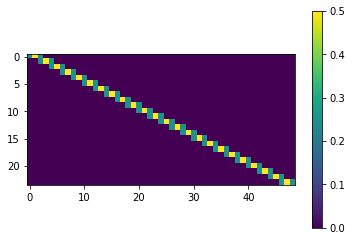

In [11]:
plt.imshow(GLOBALR)
plt.colorbar()

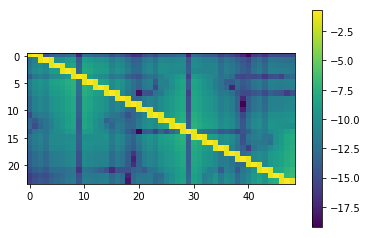

In [12]:
plt.imshow(np.log(np.abs(GLOBALR)))
plt.colorbar()

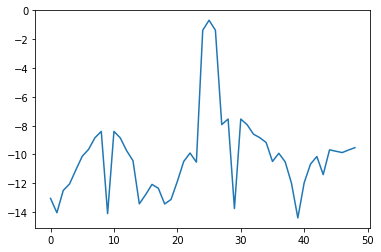

In [13]:
plt.plot(np.log(np.abs(GLOBALR[int(outputsize/2)][:])))

Energy norm: 
48.31116076291418
L2 norm: 
1.2577196317220545
H1 norm: 
33.674441756239176
Energy norm: 
3.8554810294214215
L2 norm: 
1.7786841608442236
H1 norm: 
3.7885053456583773
0.20021851879722266


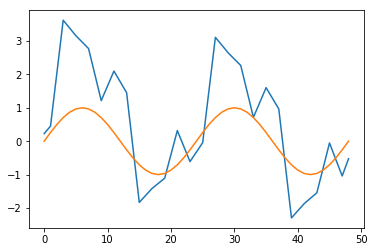

In [14]:
Xfine = np.linspace(0,1,inputsize)
Xcoarse = np.linspace(0,1,outputsize)
Mediafine = a(Xfine)
Mediacoarse = a(Xcoarse)
Urealfine = u_real(Xfine).reshape([inputsize,1])
Urealcoarse = u_real(Xcoarse).reshape([outputsize,1])
GLOBALA = np.zeros([outputsize,outputsize])

for i in range(outputsize):
    for j in range(outputsize):
        basisi = GLOBALR[i][:]
        basisj = GLOBALR[j][:]
        gxbasisi = np.gradient(basisi,h)
        gxbasisj = np.gradient(basisj,h)
        GLOBALA[i][j] = (np.sum(Mediafine*gxbasisi*gxbasisj))*(H)
        
GLOBALF = np.zeros([outputsize,1])
F = rightf(Xfine)
for j in range(outputsize):
        basisj = GLOBALR[j][:]
        GLOBALF[j][0] = (np.sum(F*basisj))*(H)
        
GLOBALU = np.linalg.solve(GLOBALA,GLOBALF)
GlobalU = np.zeros([inputsize,1])
for i in range(outputsize):
    GlobalU = GlobalU + GLOBALU[i]*GLOBALR[i][:].reshape([inputsize,1])
    
deltaU = GlobalU - Urealfine    
Mediafine = a(np.linspace(0,1,inputsize-1)).reshape([inputsize-1,1])
energynorm = np.sqrt(np.sum(np.multiply(np.multiply(np.diff(Urealfine,axis=0)/h,np.diff(Urealfine,axis=0)/h),Mediafine)*(h)))
l2norm = np.sqrt((np.sum((Urealfine)**2)*(h)))
h1norm = np.sqrt((np.sum((Urealfine)**2)*(h))+(np.sum((np.diff(Urealfine,axis=0)/h)**2)*(h)))

print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.diff(deltaU,axis=0)/h,np.diff(deltaU,axis=0)/h),Mediafine)*(h))))
print('L2 norm: ')
print(np.sqrt((np.sum((deltaU)**2)*(h))))
print('H1 norm: ')
print(np.sqrt((np.sum((deltaU)**2)*(h))+(np.sum((np.diff(deltaU,axis=0)/h)**2)*(h))))


print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.diff(deltaU,axis=0)/h,np.diff(deltaU,axis=0)/h),Mediafine)*(h)))/energynorm)
print('L2 norm: ')
print(np.sqrt((np.sum((deltaU)**2)*(h)))/l2norm)
print('H1 norm: ')
print(np.sqrt((np.sum((deltaU)**2)*(h))+(np.sum((np.diff(deltaU,axis=0)/h)**2)*(h)))/h1norm)
print(Rhonew)

plt.plot(GlobalU)
plt.plot(Urealfine)

Energy norm: 
65.04265257208782
L2 norm: 
2.3958213124493675
H1 norm: 
46.357045297567225
Energy norm: 
5.192059573594374
L2 norm: 
3.3882029930884037
H1 norm: 
5.21666408937519
0.20506645163752543


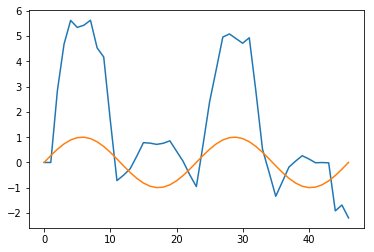

In [15]:
outputsize = np.size(LOCALR,0)
inputsize = np.size(LOCALR,1)
Xfine = np.linspace(0,1,inputsize)
Xcoarse = np.linspace(0,1,outputsize)
Mediafine = a(Xfine)
Mediacoarse = a(Xcoarse)
Urealfine = u_real(Xfine).reshape([inputsize,1])
Urealcoarse = u_real(Xcoarse).reshape([outputsize,1])
h = 1/(inputsize-1)
H = 1/(outputsize-1)
LOCALA = np.zeros([outputsize,outputsize])
for i in range(outputsize):
    for j in range(outputsize):
        basisi = LOCALR[i][:]
        basisj = LOCALR[j][:]
        gxbasisi = np.gradient(basisi,h)
        gxbasisj = np.gradient(basisj,h)
        LOCALA[i][j] = (np.sum(Mediafine*gxbasisi*gxbasisj))*(H)
        
LOCALF = np.zeros([outputsize,1])
F = rightf(Xfine)
for j in range(outputsize):
        basisj = LOCALR[j][:]
        LOCALF[j][0] = (np.sum(F*basisj))*(H)
        
LOCALU = np.linalg.solve(LOCALA,LOCALF)
LocalU = np.zeros([inputsize,1])
for i in range(outputsize):
    LocalU = LocalU + LOCALU[i]*LOCALR[i][:].reshape([inputsize,1])
    
deltaU = LocalU - Urealfine    

Mediafine = a(np.linspace(0,1,inputsize-1)).reshape([inputsize-1,1])
energynorm = np.sqrt(np.sum(np.multiply(np.multiply(np.diff(Urealfine,axis=0)/h,np.diff(Urealfine,axis=0)/h),Mediafine)*(h)))
l2norm = np.sqrt((np.sum((Urealfine)**2)*(h)))
h1norm = np.sqrt((np.sum((Urealfine)**2)*(h))+(np.sum((np.diff(Urealfine,axis=0)/h)**2)*(h)))

print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.diff(deltaU,axis=0)/h,np.diff(deltaU,axis=0)/h),Mediafine)*(h))))
print('L2 norm: ')
print(np.sqrt((np.sum((deltaU)**2)*(h))))
print('H1 norm: ')
print(np.sqrt((np.sum((deltaU)**2)*(h))+(np.sum((np.diff(deltaU,axis=0)/h)**2)*(h))))


print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.diff(deltaU,axis=0)/h,np.diff(deltaU,axis=0)/h),Mediafine)*(h)))/energynorm)
print('L2 norm: ')
print(np.sqrt((np.sum((deltaU)**2)*(h)))/l2norm)
print('H1 norm: ')
print(np.sqrt((np.sum((deltaU)**2)*(h))+(np.sum((np.diff(deltaU,axis=0)/h)**2)*(h)))/h1norm)


print(current_rho)

plt.plot(LocalU)
plt.plot(Urealfine)